In [1]:
import pandas as pd

df = pd.read_csv("dataset_mood_smartphone.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376912 entries, 0 to 376911
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  376912 non-null  int64  
 1   id          376912 non-null  object 
 2   time        376912 non-null  object 
 3   variable    376912 non-null  object 
 4   value       376710 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.4+ MB


In [2]:
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.drop("Unnamed: 0", axis=1)
    df['time'] = pd.to_datetime(df["time"])
    
    var_names = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen',
                 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
                 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
                 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

    user_ids = ['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07', 'AS14.08',
           'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15', 'AS14.16', 'AS14.17',
           'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24', 'AS14.25', 'AS14.26', 'AS14.27',
           'AS14.28', 'AS14.29', 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']


    # helper to concat dfs grouped by var name
    df_out = pd.DataFrame()

    # group by variable type
    for name in var_names:
        df_var_tmp = df[df['variable'] == name]

        # helper to concat dfs grouped by id
        df_var = pd.DataFrame()

        # group by user id
        for id in user_ids:
            df_id_tmp = df_var_tmp[df_var_tmp['id'] == id]

            # remove missing values
            df_id_tmp = df_id_tmp[df_id_tmp['value'].notna()]

            # drop values outside the range

            # 1 to 10
            if name == "mood":
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= 1) & (df_id_tmp['value'] <= 10)]
            # 0 to 1
            elif name == "activity":
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= 0) & (df_id_tmp['value'] <= 1)]
            # -2 to 2
            elif name in ['circumplex.arousal', 'circumplex.valence']:
                df_id_tmp = df_id_tmp[(df_id_tmp['value'] >= -2) & (df_id_tmp['value'] <= 2)]
            # 1
            elif name in ['sms', 'call']:
                df_id_tmp = df_id_tmp[df_id_tmp['value'] == 1]
            # else is time data, so > 0
            else:
                df_id_tmp = df_id_tmp[df_id_tmp['value'] >= 0]

            # remove outliers bellow 01 quantile and above 99 quantile
            lower = df_id_tmp['value'].quantile(.01)
            upper = df_id_tmp['value'].quantile(.99)

            # outliers replaced with lower and upper value respectively
            df_id_tmp['value'] = df_id_tmp['value'].clip(lower=lower, upper=upper)

            # drop duplicates with the exact same date by taking a mean of them
            df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'], df_id_tmp['variable']])['value'].mean().reset_index()

            # grouping by day
            if name in ['mood', 'circumplex.arousal', 'circumplex.valence']:
                df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'].dt.date, df_id_tmp['variable']])['value'].mean().reset_index()
            else:
                df_id_tmp = df_id_tmp.groupby([df_id_tmp['id'], df_id_tmp['time'].dt.date, df_id_tmp['variable']])['value'].sum().reset_index()

            # concat df
            df_var = pd.concat([df_var, df_id_tmp])

        # concat df
        df_out = pd.concat([df_out, df_var])
    
    df_out.sort_values(by = ['id', 'time'], inplace=True)
    
    df_out.reset_index(drop=True, inplace=True)
    
    return df_out

df_clean = clean_dataset(df)
df_clean.head()

,id,time,variable,value
0,AS14.01,2014-02-17,call,2.0
1,AS14.01,2014-02-18,call,1.0
2,AS14.01,2014-02-19,call,7.0
3,AS14.01,2014-02-19,sms,2.0
4,AS14.01,2014-02-20,call,2.0


In [3]:
def pivot_to_wide(df: pd.DataFrame) -> pd.DataFrame:
    return pd.pivot(df, index=['id','time'], columns='variable', values = 'value').reset_index()
    
wide = pivot_to_wide(df_clean)
wide.head()

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,2.0
3,AS14.01,2014-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0
4,AS14.01,2014-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### Imputing missing data

Filling zeroes to the variables starting with appCat, activity, call and sms have the following meaning:
- appCat: zero time spent on this appCat
- activity: zero time spent on the phone
- call: zero calls have been done
- sms: zero SMSs have been sent
    
Assign mean values to the following variables "circumplex.arousal", "circumplex.valence", "mood" because we have no baseline to compare to, as to say, for the starting values. By assigning these values to the mean we would be unbiased towards any side.

In [8]:
# Save df with these variables
no_time_vars = ["circumplex.arousal", "circumplex.valence", "mood"]
partial_df = wide[no_time_vars]


# Fill NaN values for time indiciating vars with zeroes
dropped_df = wide.drop(no_time_vars, axis=1).fillna(0)
filled_df = pd.merge(dropped_df, partial_df, left_index=True, right_index=True)

#### Trimming time series data

In [10]:
# can be used to check per user
user_ids = ['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07', 'AS14.08',
           'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15', 'AS14.16', 'AS14.17',
           'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24', 'AS14.25', 'AS14.26', 'AS14.27',
           'AS14.28', 'AS14.29', 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']

# trimming time series per user to remove prolonged periods of missing data
# trimming is based on lack of mood value which is our target variable
trimmed = pd.DataFrame()
for id in user_ids:
    partial_df = filled_df[filled_df["id"] == id]
    start_date = partial_df.dropna(subset=['mood']).reset_index().head(1)['time'].values[0]
    end_date = partial_df.dropna(subset=['mood']).reset_index().tail(1)['time'].values[0]
    trimmed_df = partial_df[(partial_df['time'] >= start_date) & (partial_df['time'] <= end_date)]
    trimmed = pd.concat([trimmed, trimmed_df]).reset_index(drop=True)

    
    
trimmed.head()

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,circumplex.arousal,circumplex.valence,mood
0,AS14.01,2014-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.25,0.750000,6.250000
1,AS14.01,2014-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.333333,6.333333
2,AS14.01,2014-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN
3,AS14.01,2014-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
4,AS14.01,2014-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN


/Users/kuba/anaconda3/envs/Uni/lib/python3.10/site-packages/missingno/missingno.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


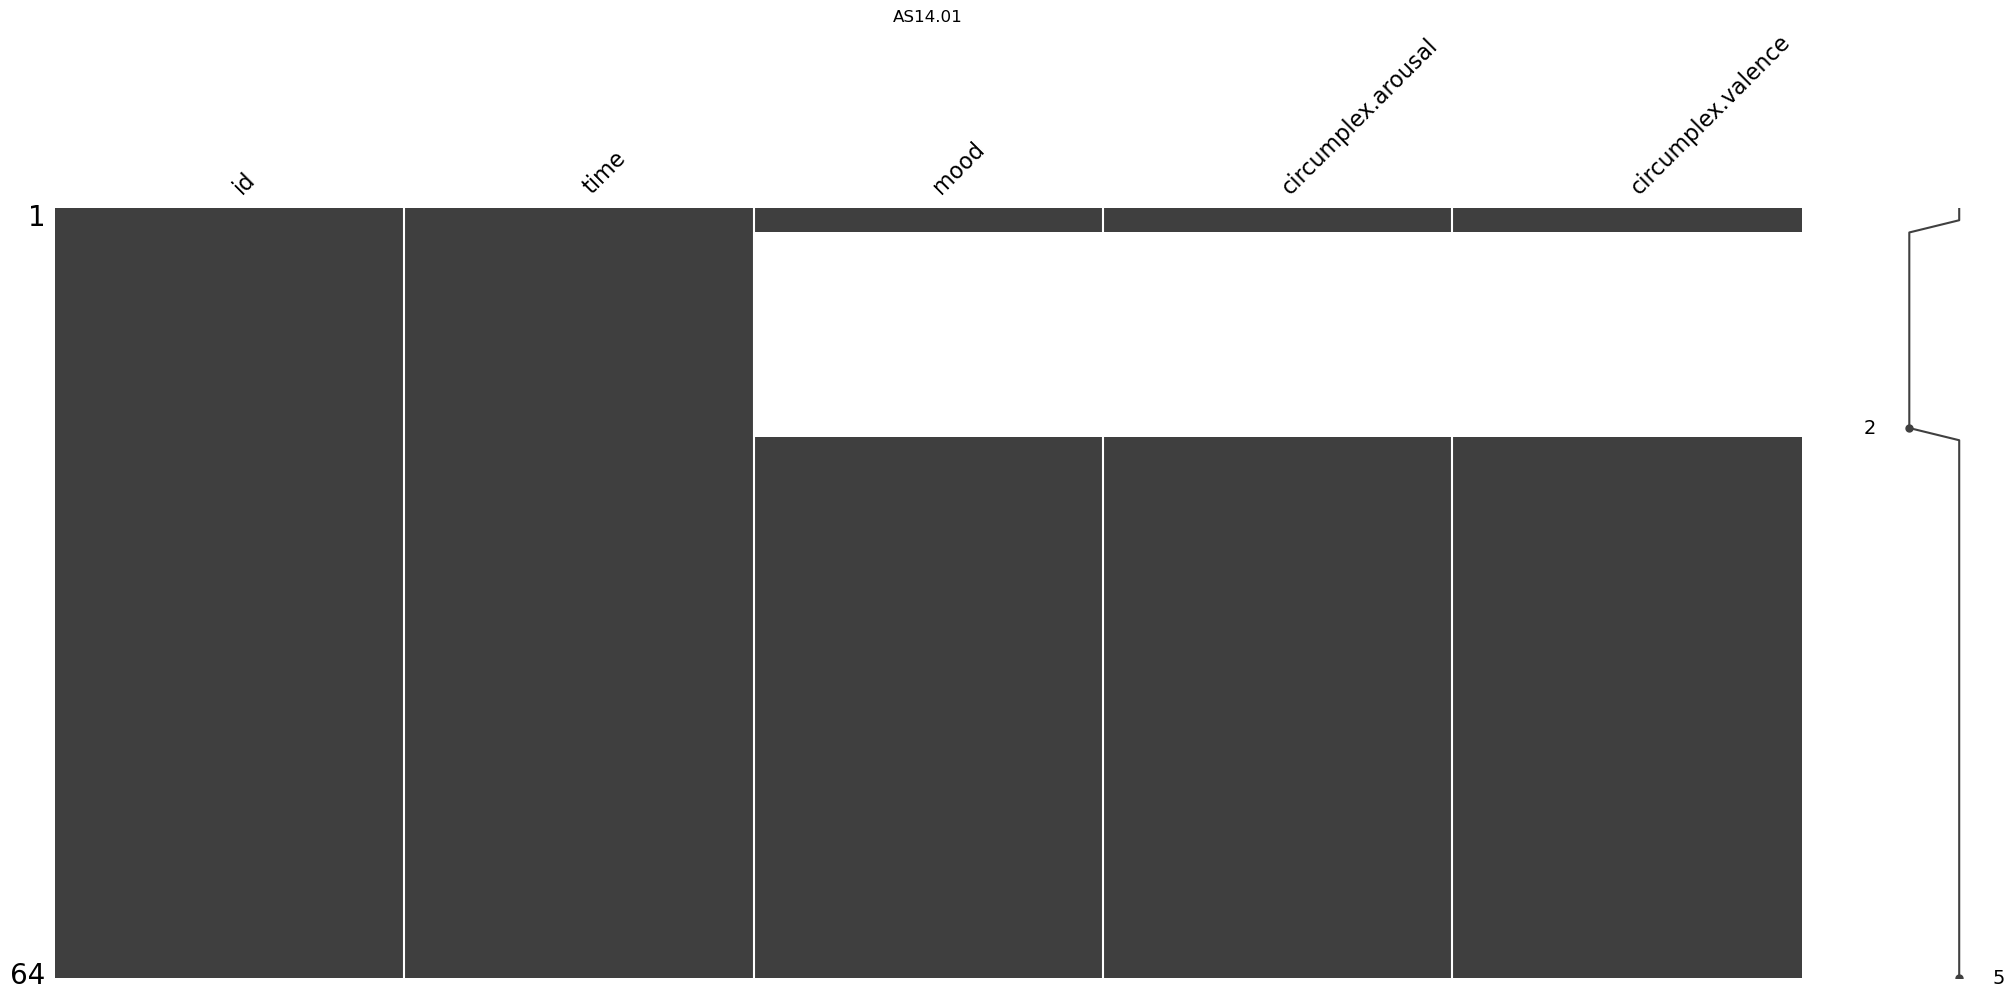

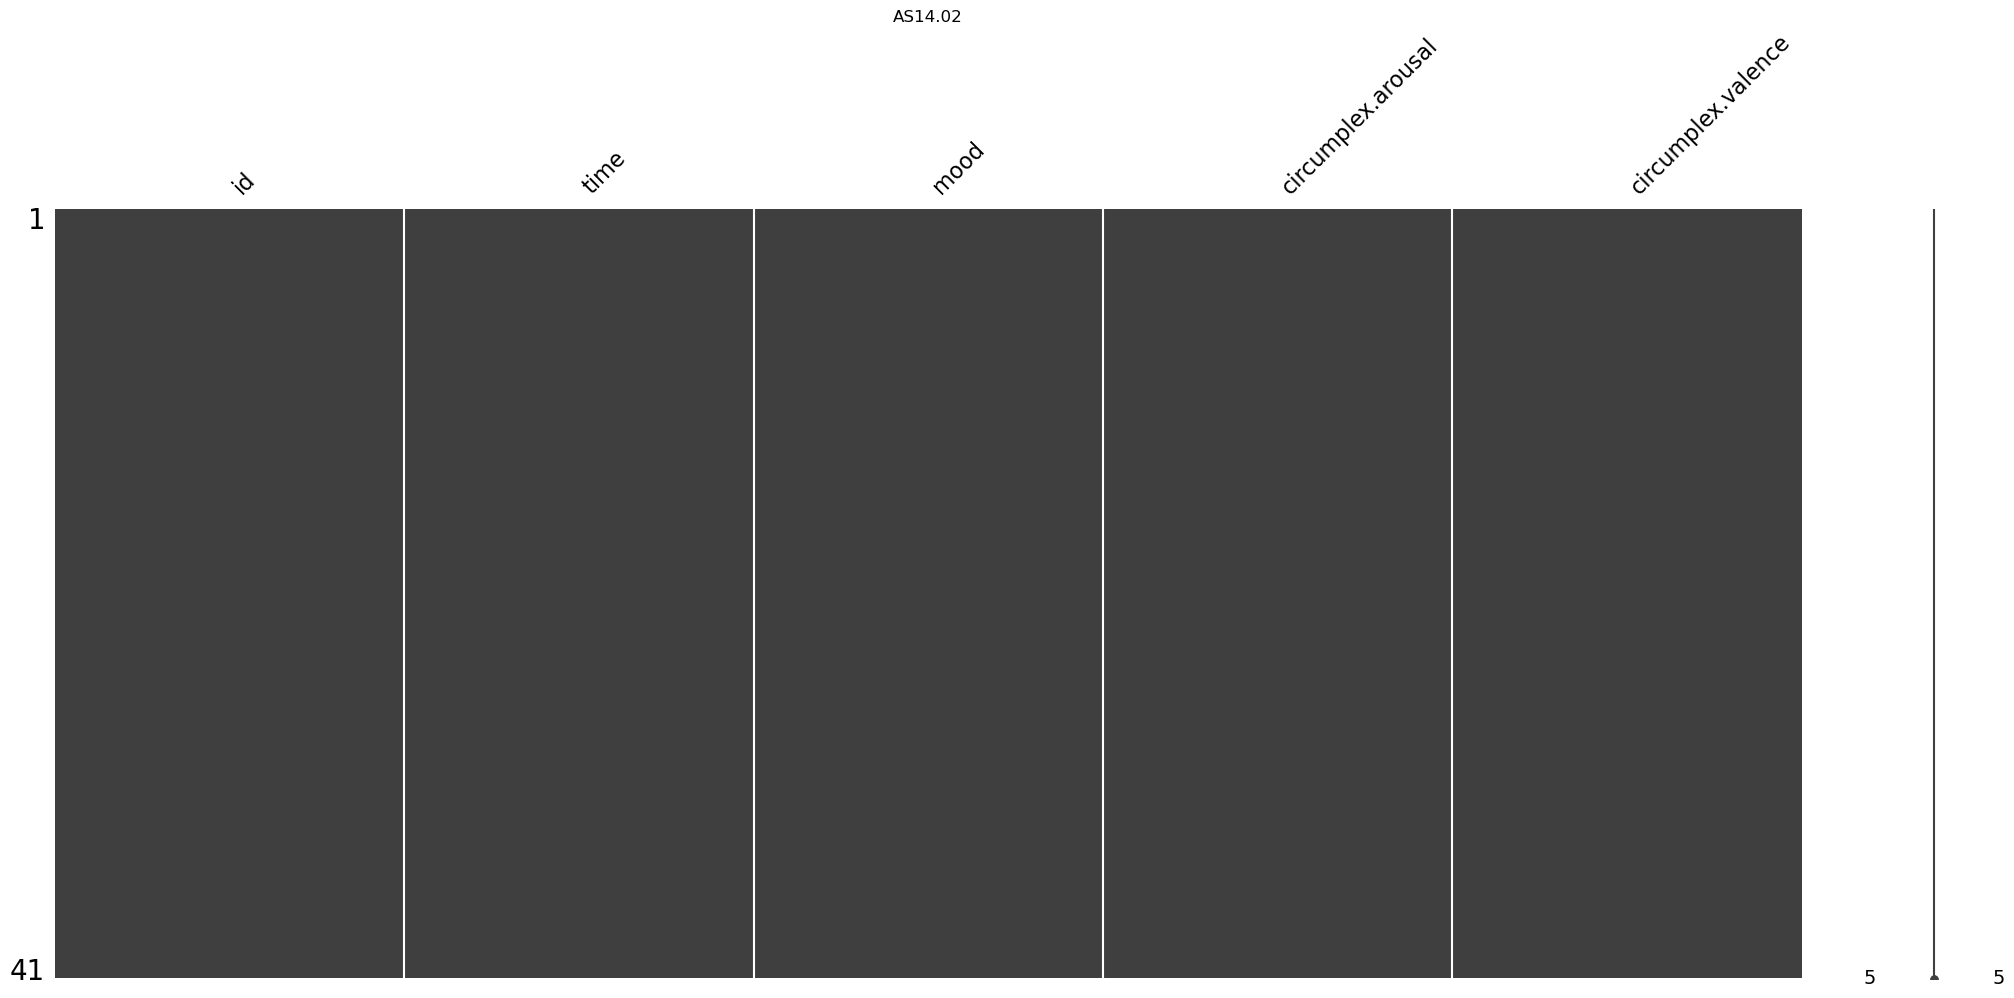

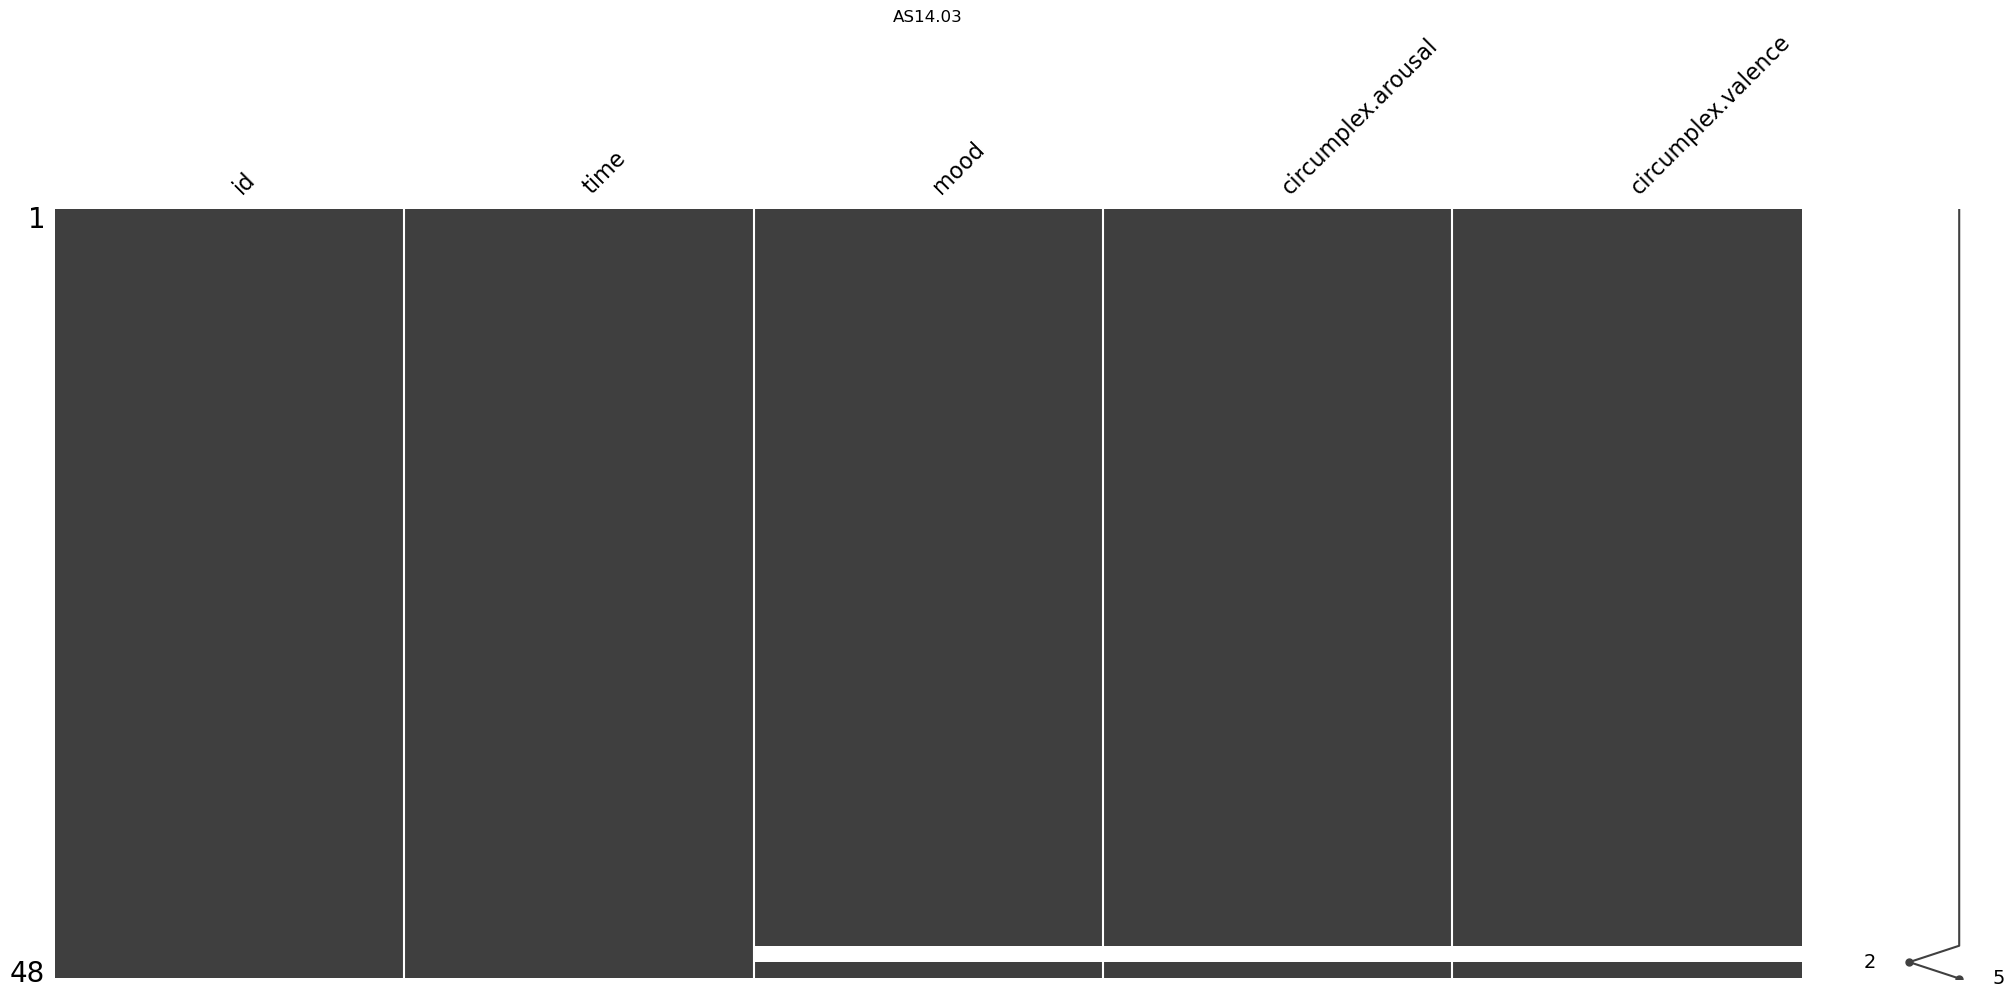

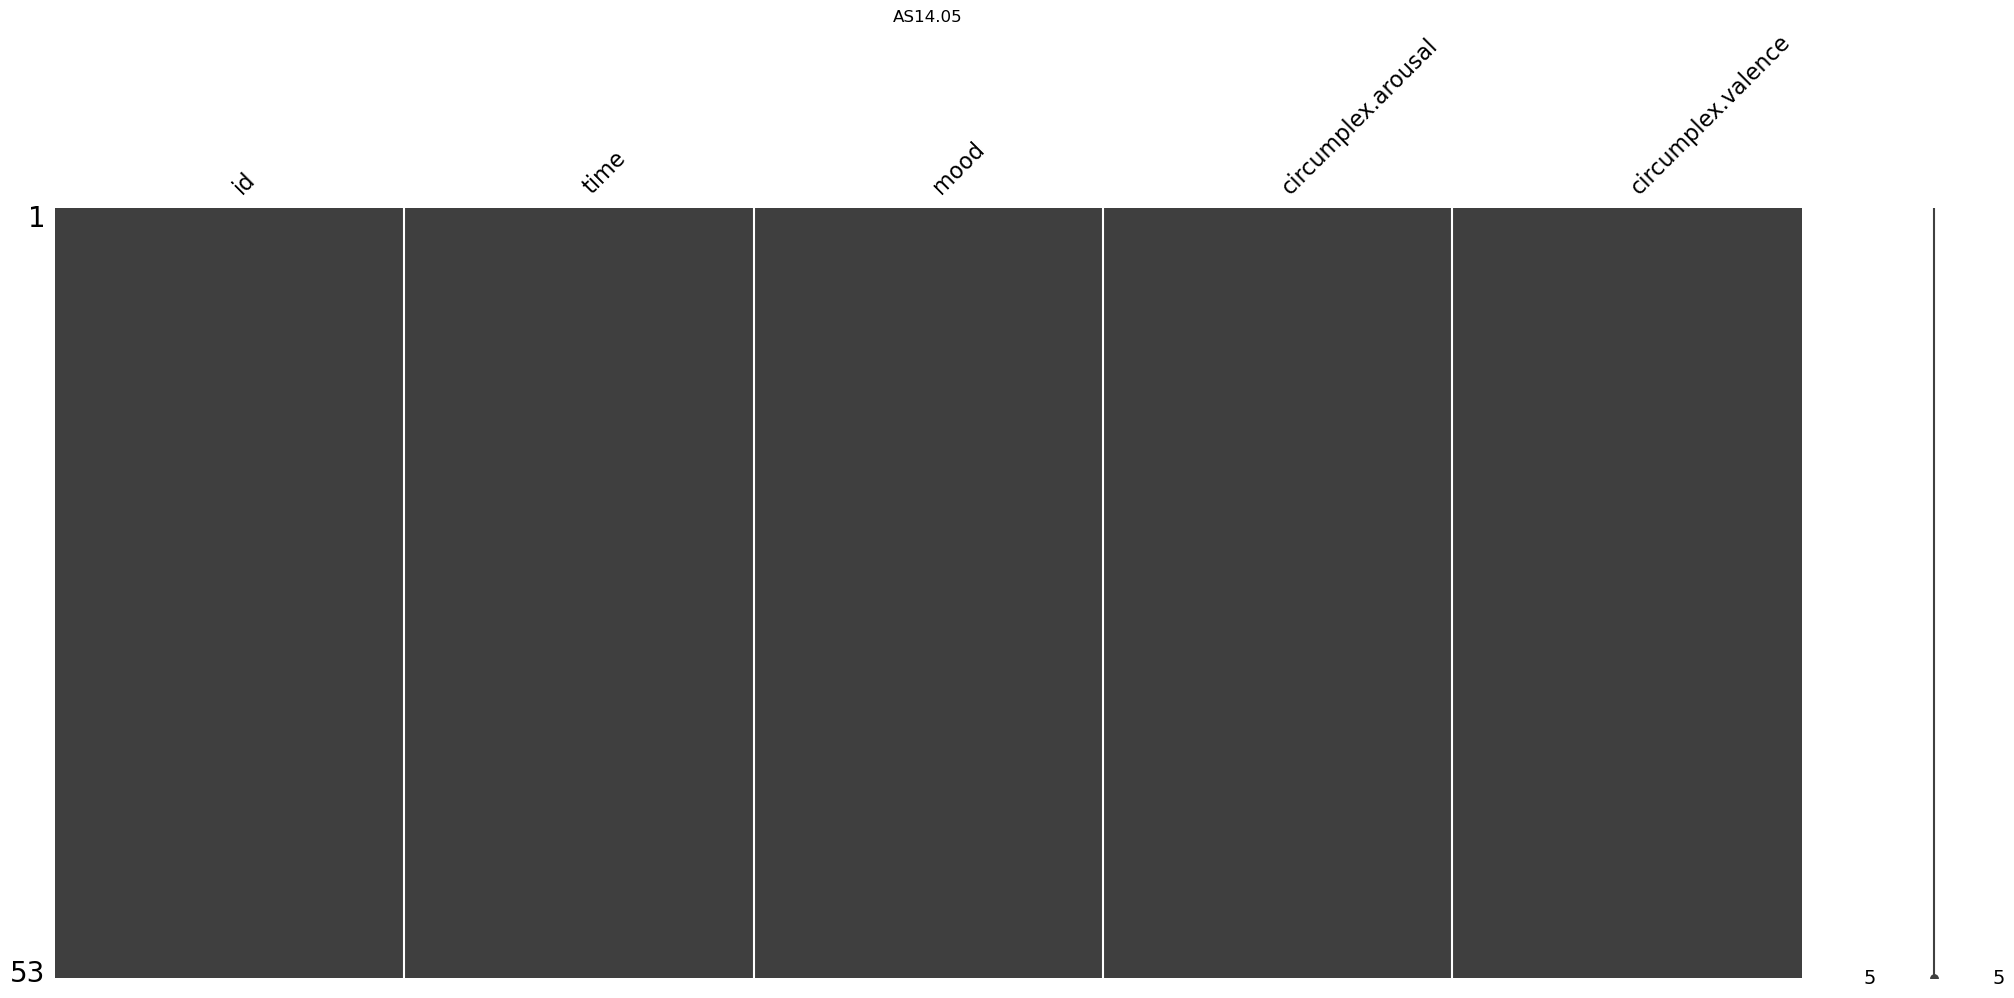

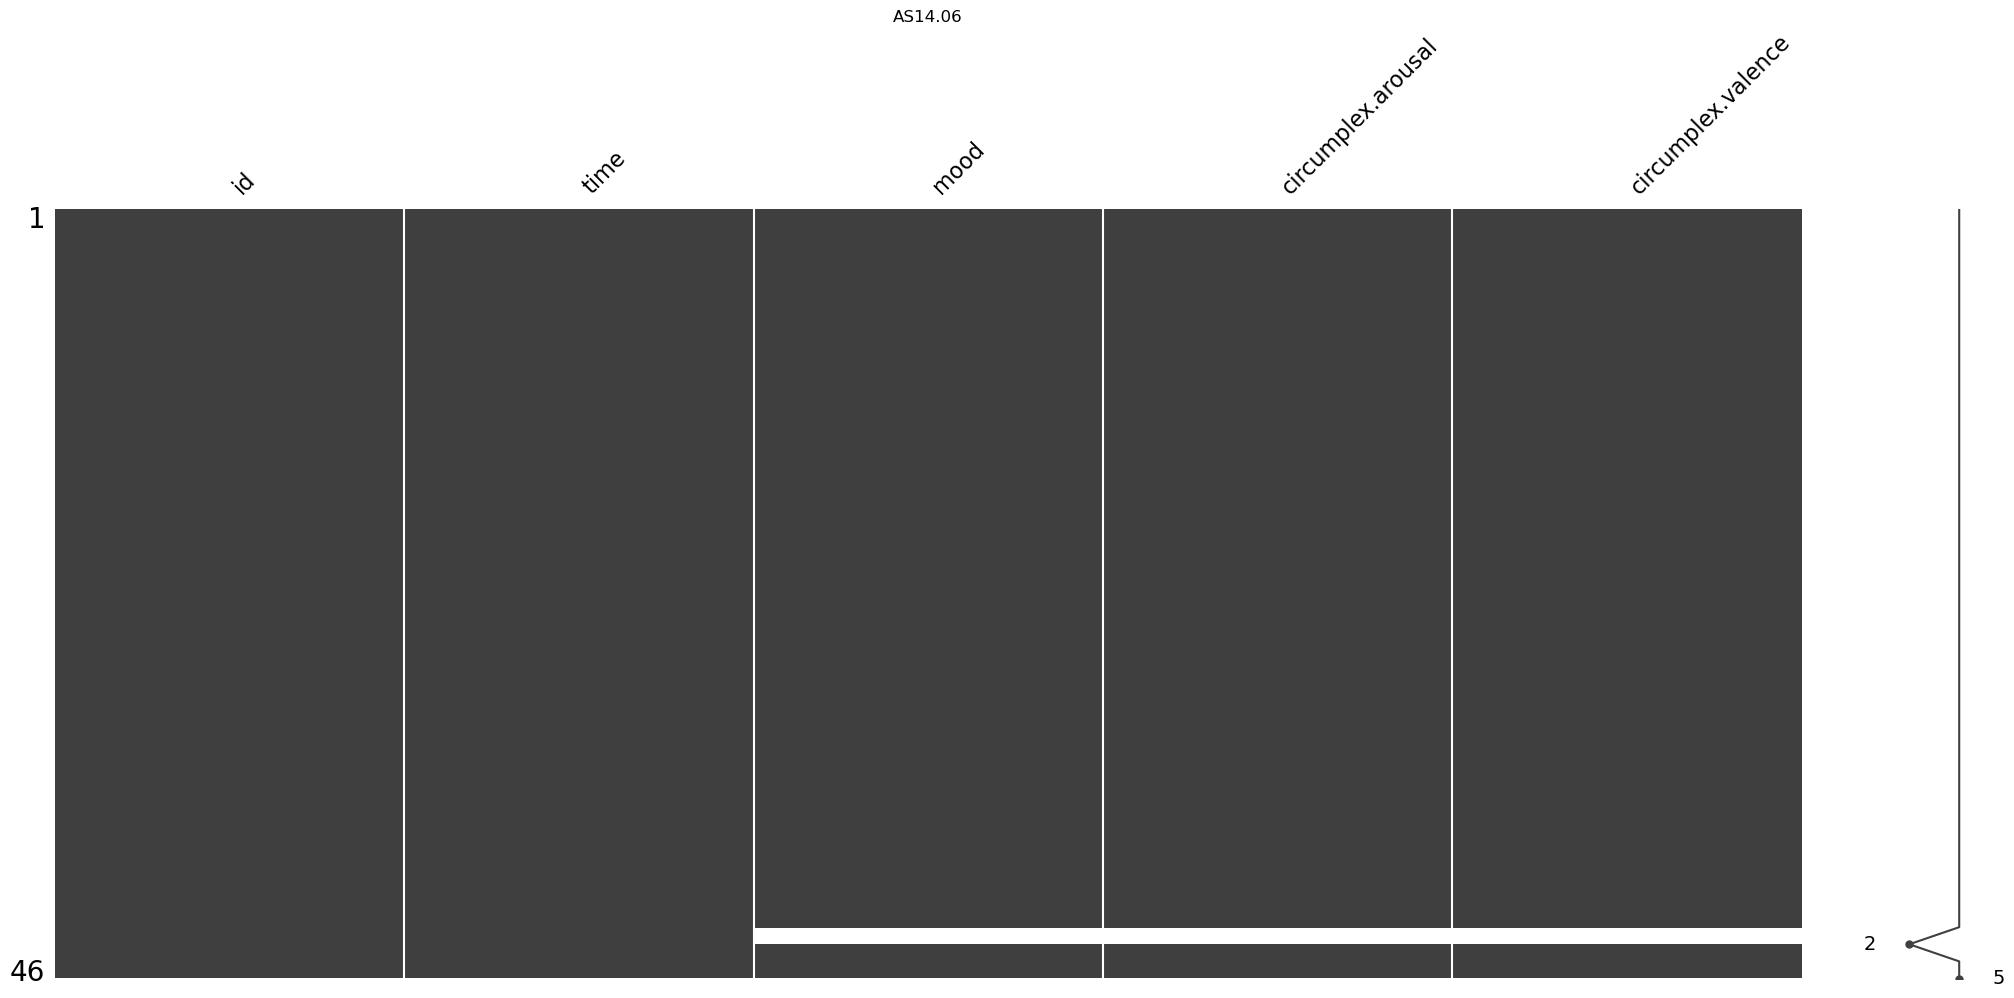

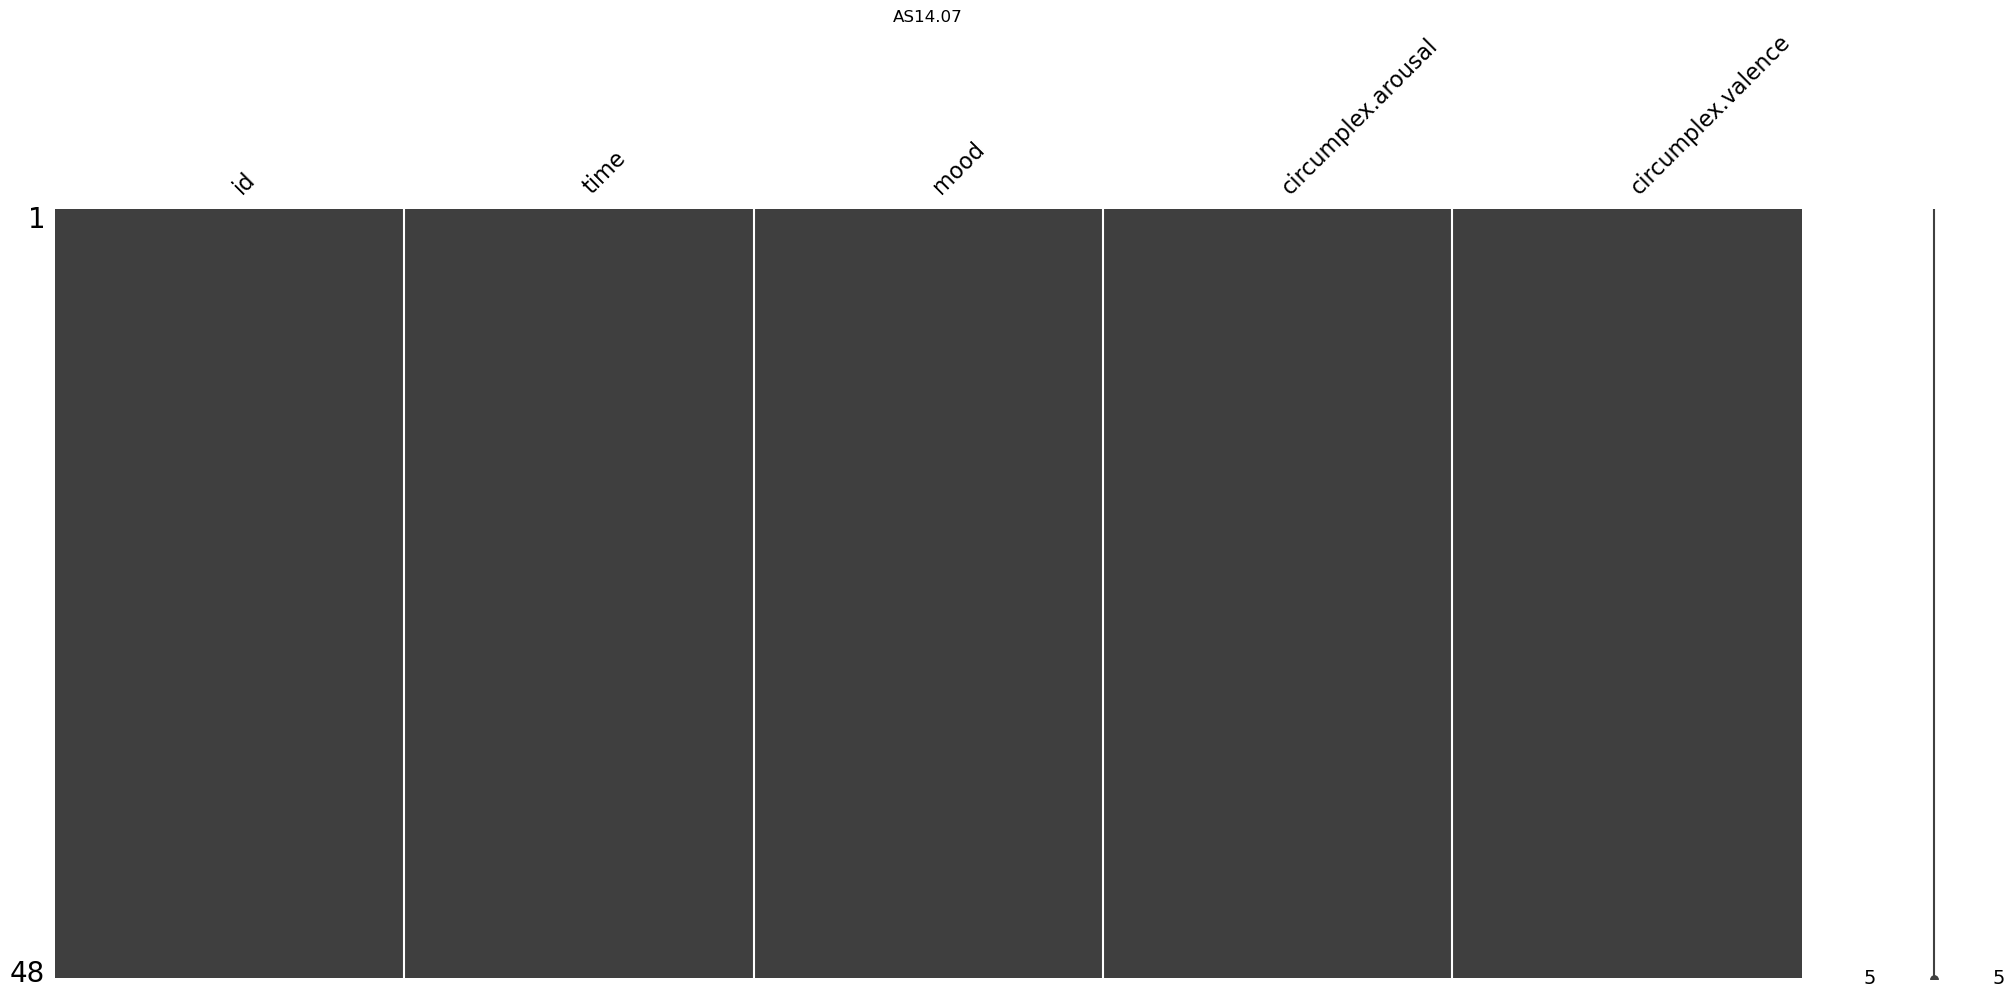

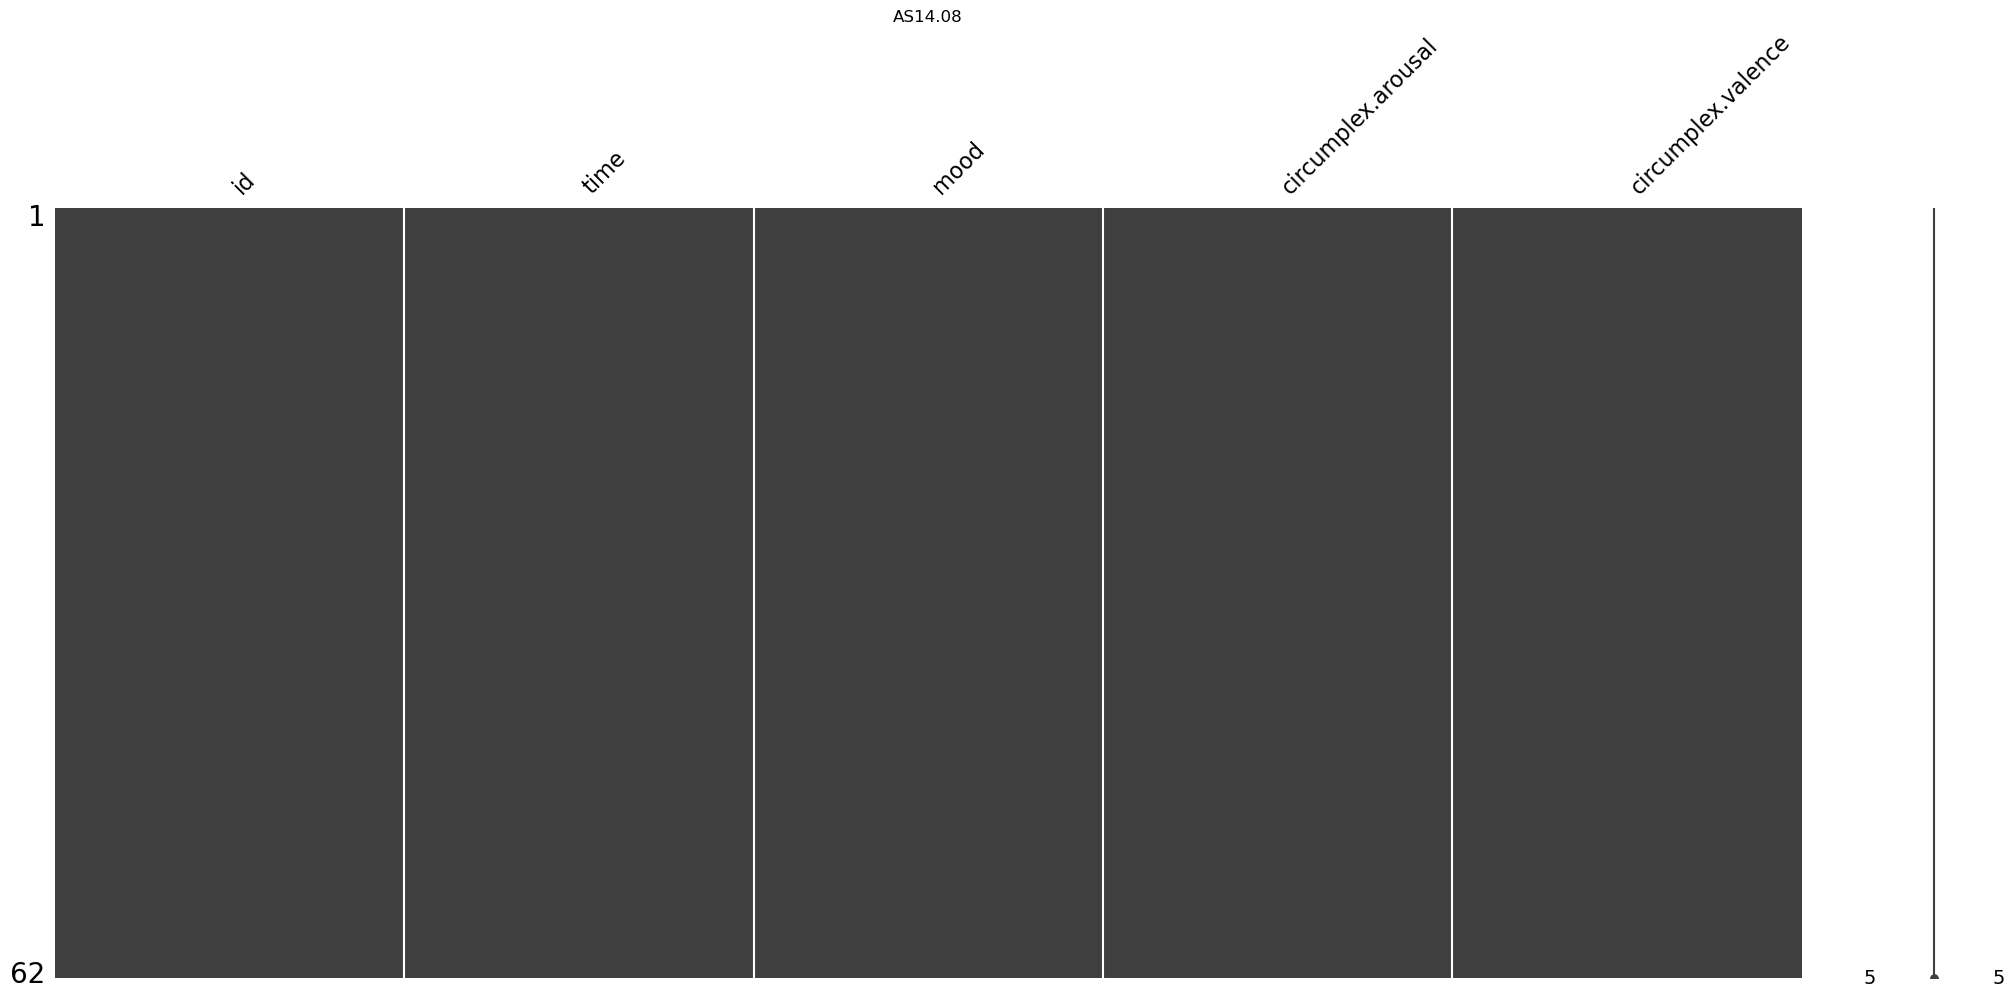

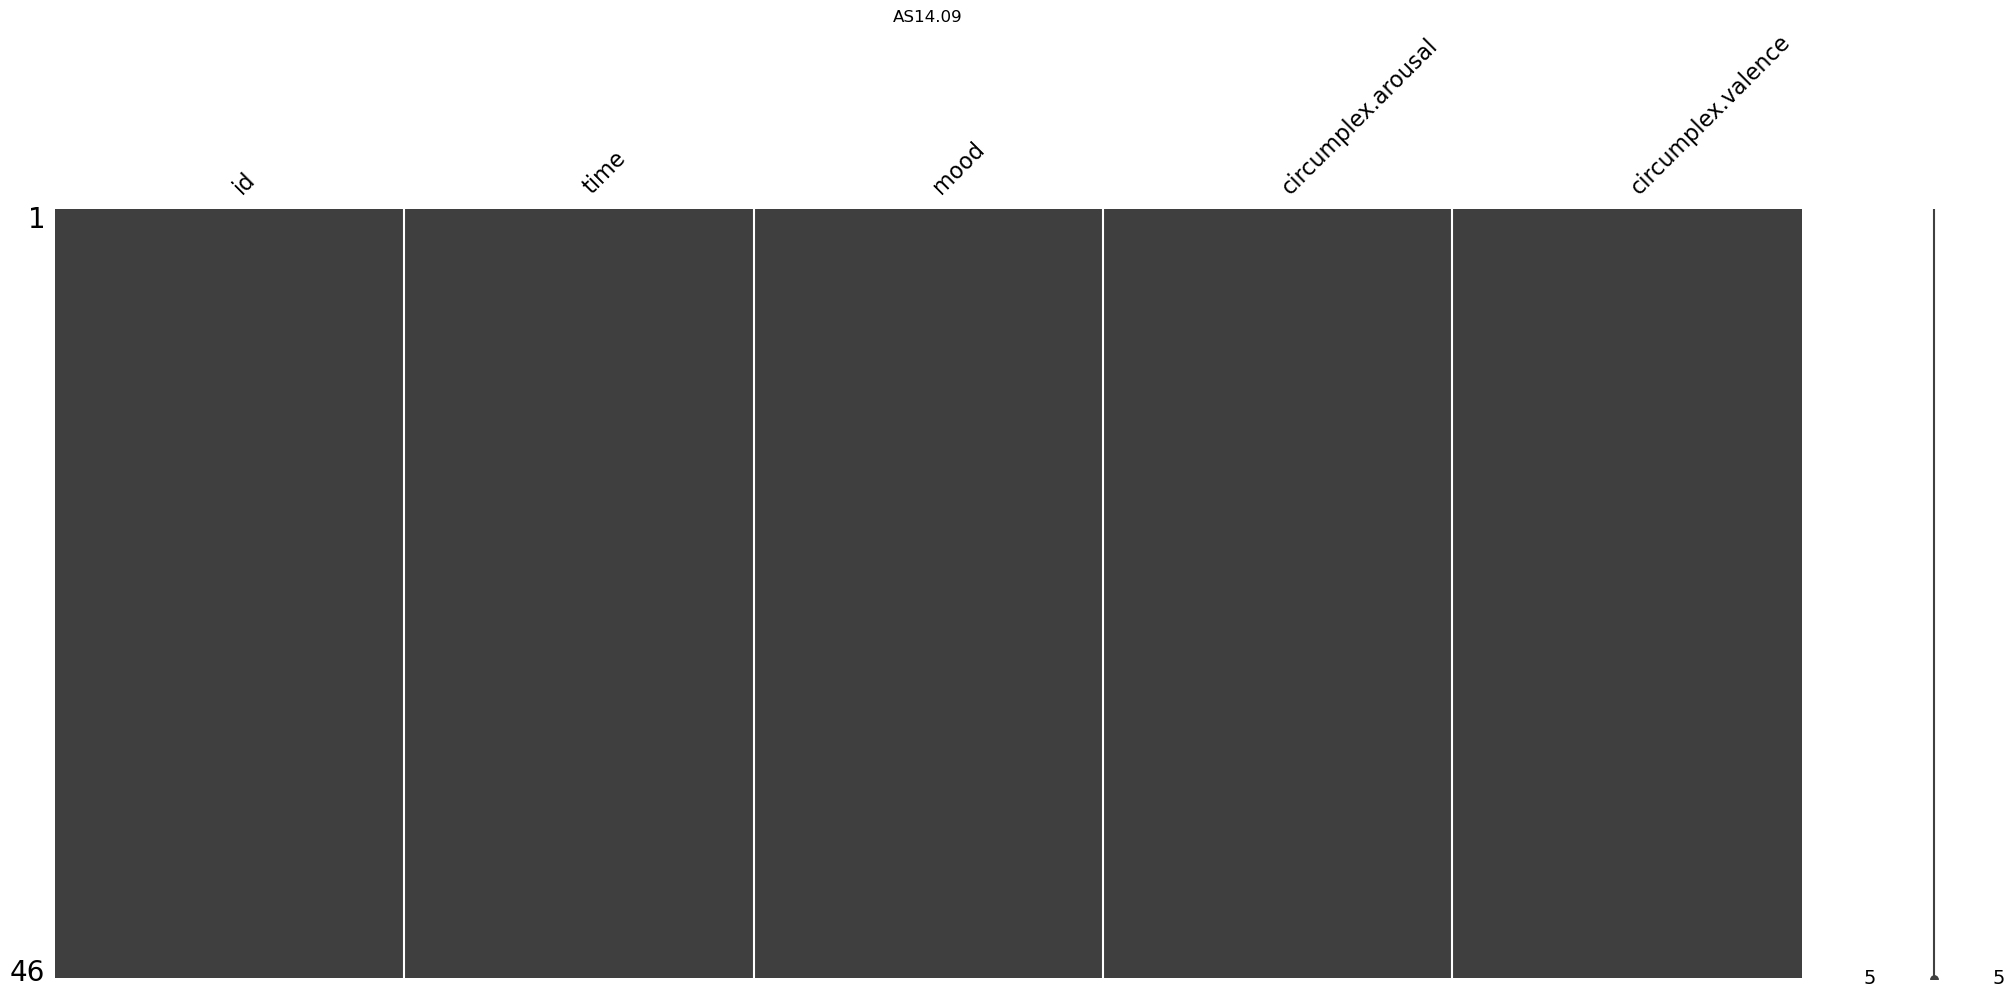

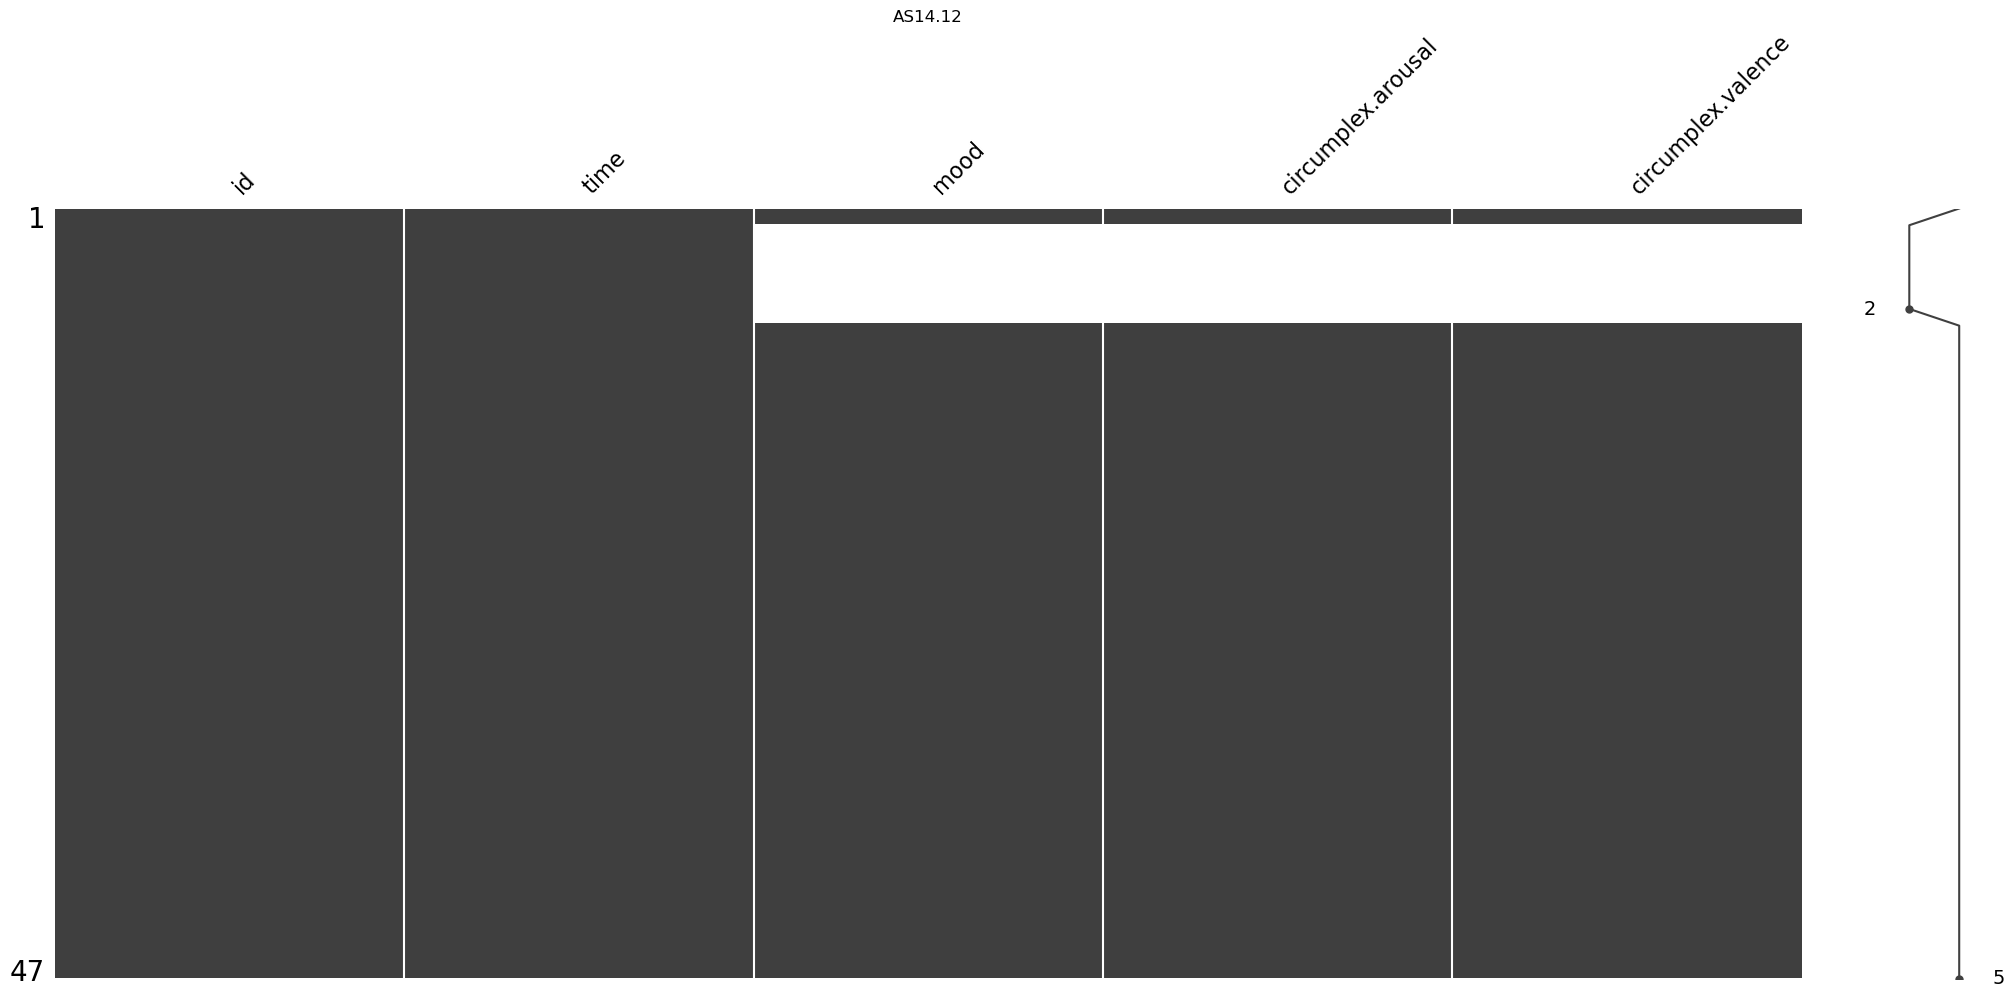

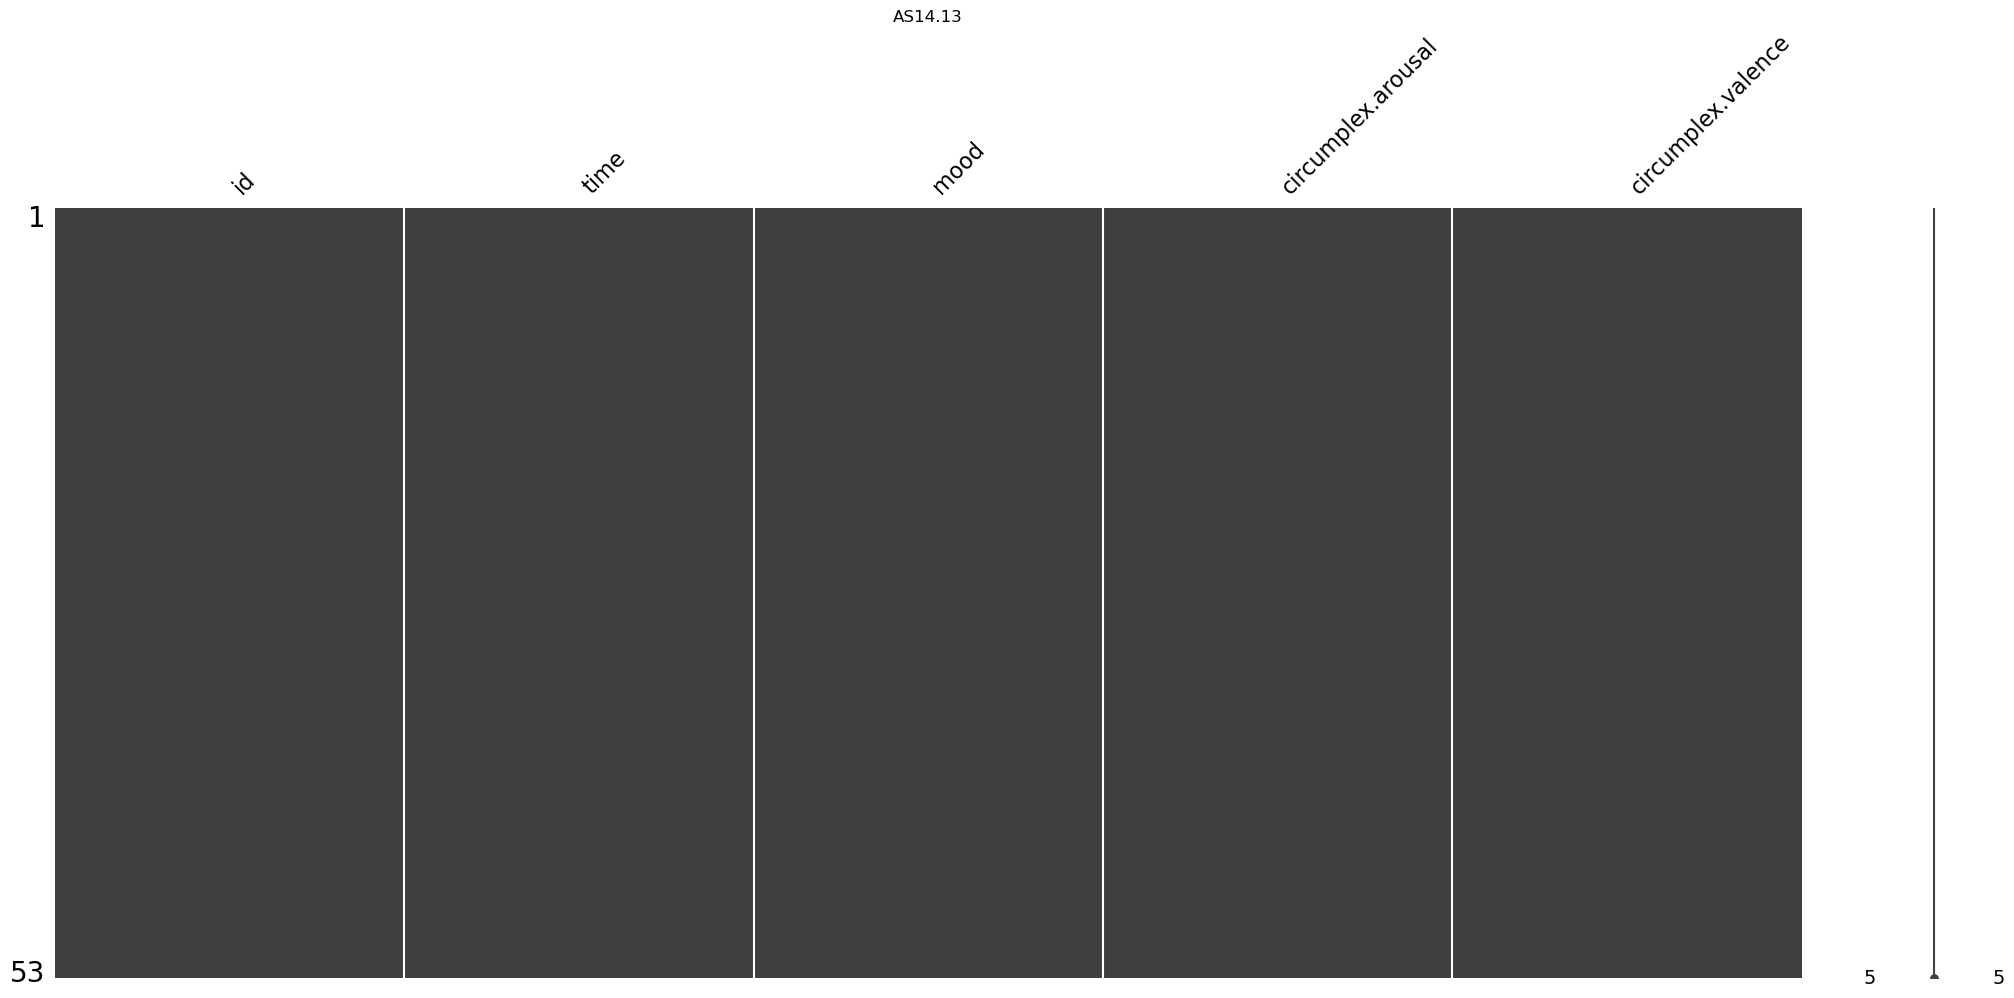

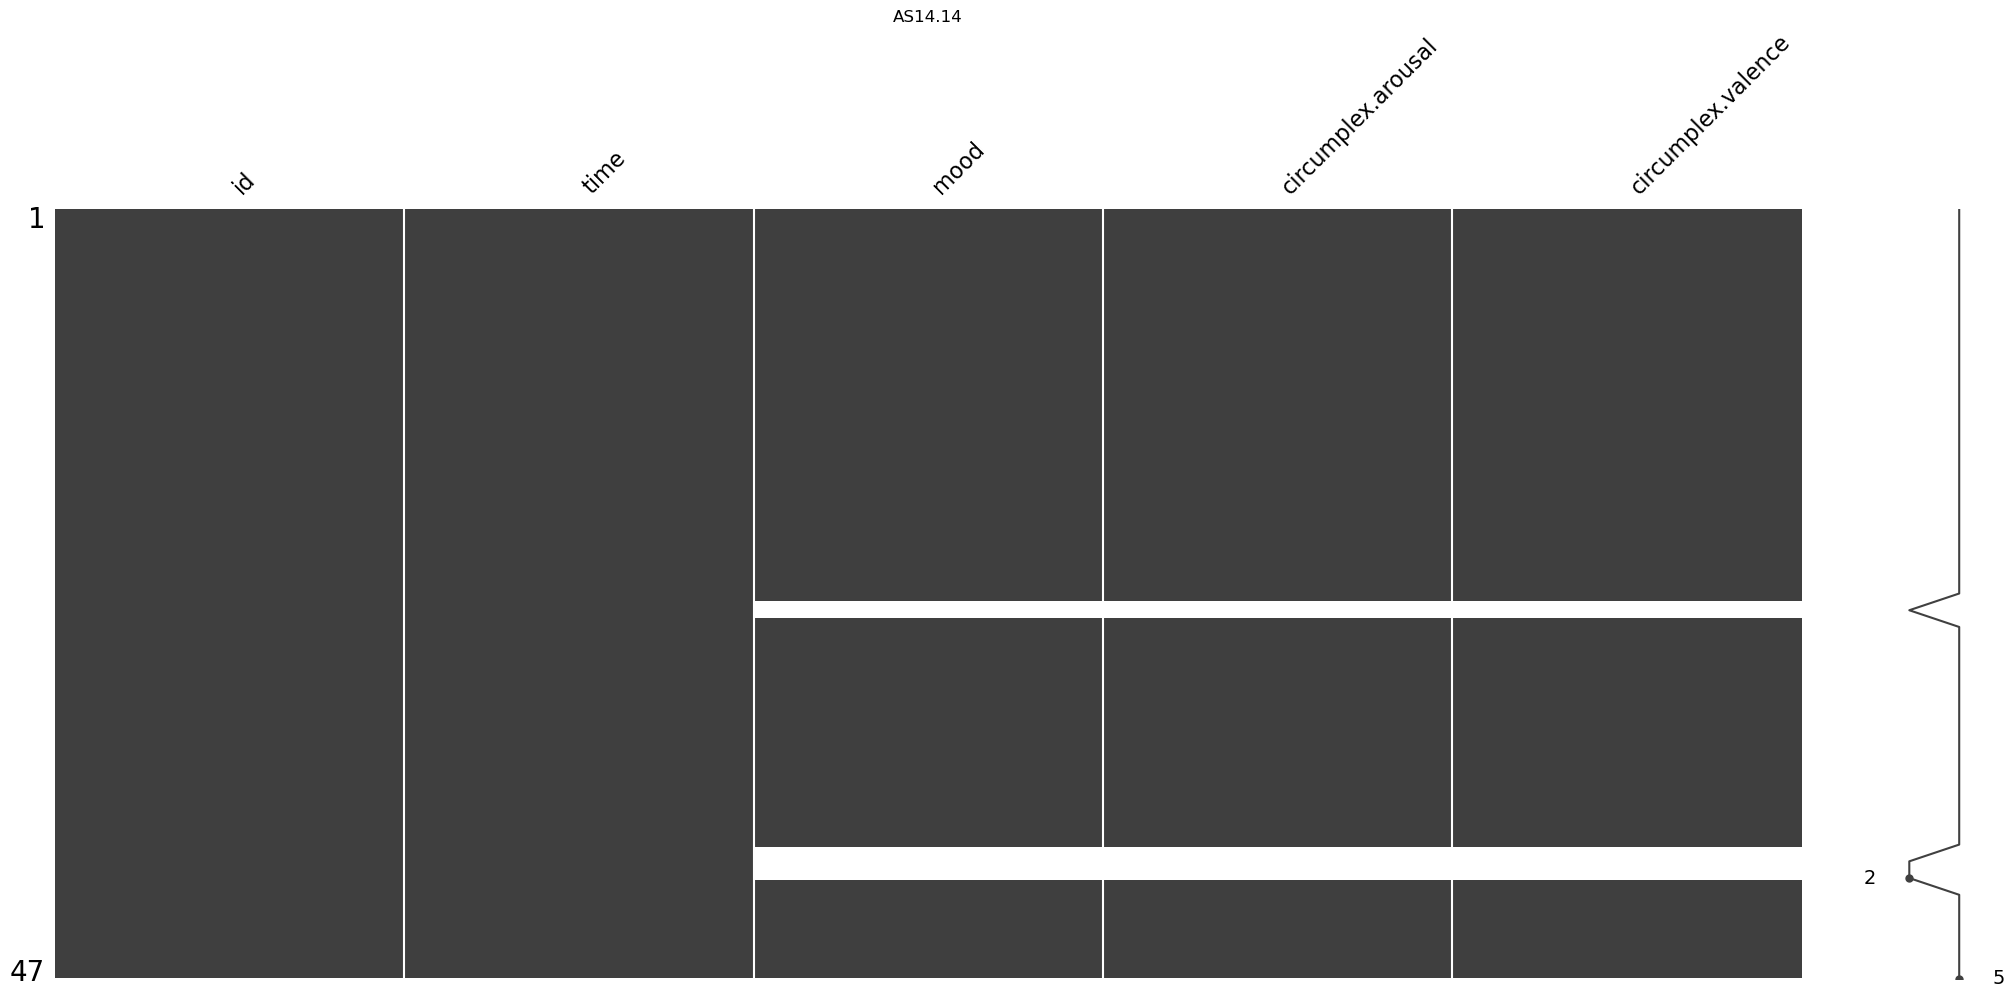

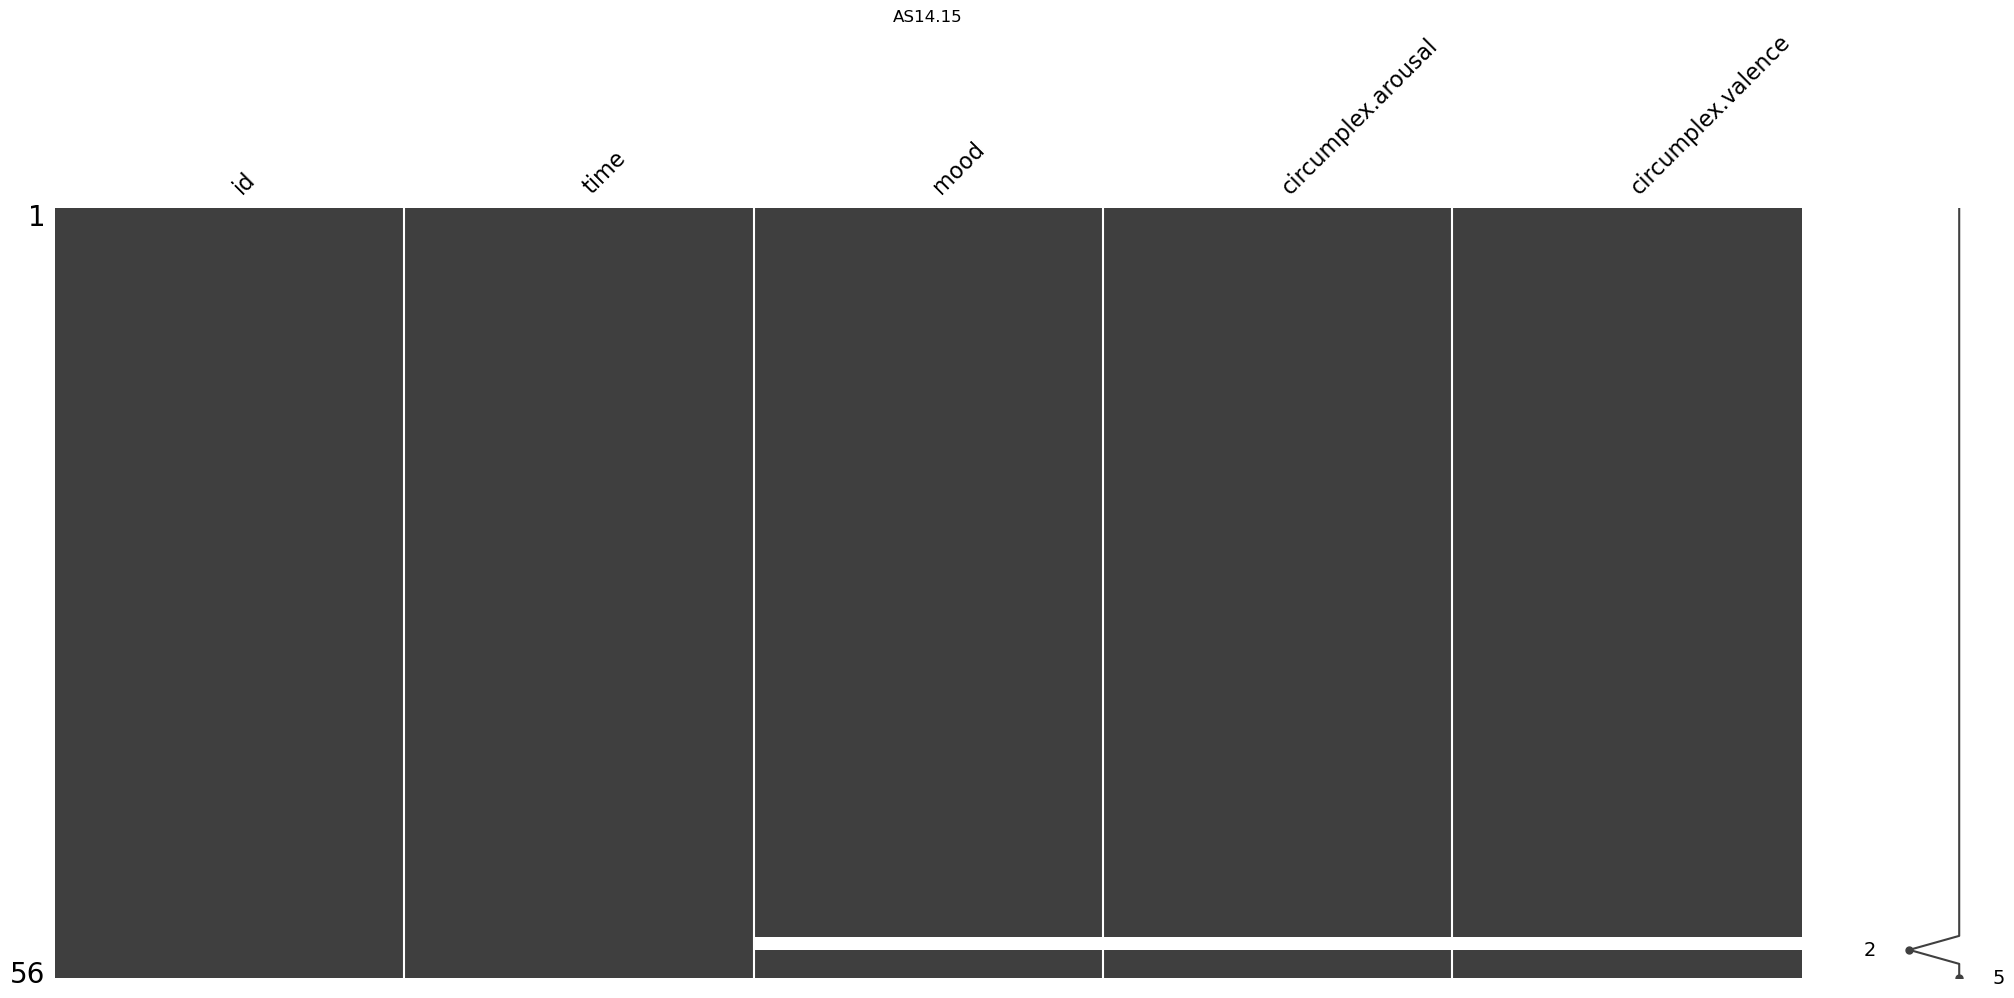

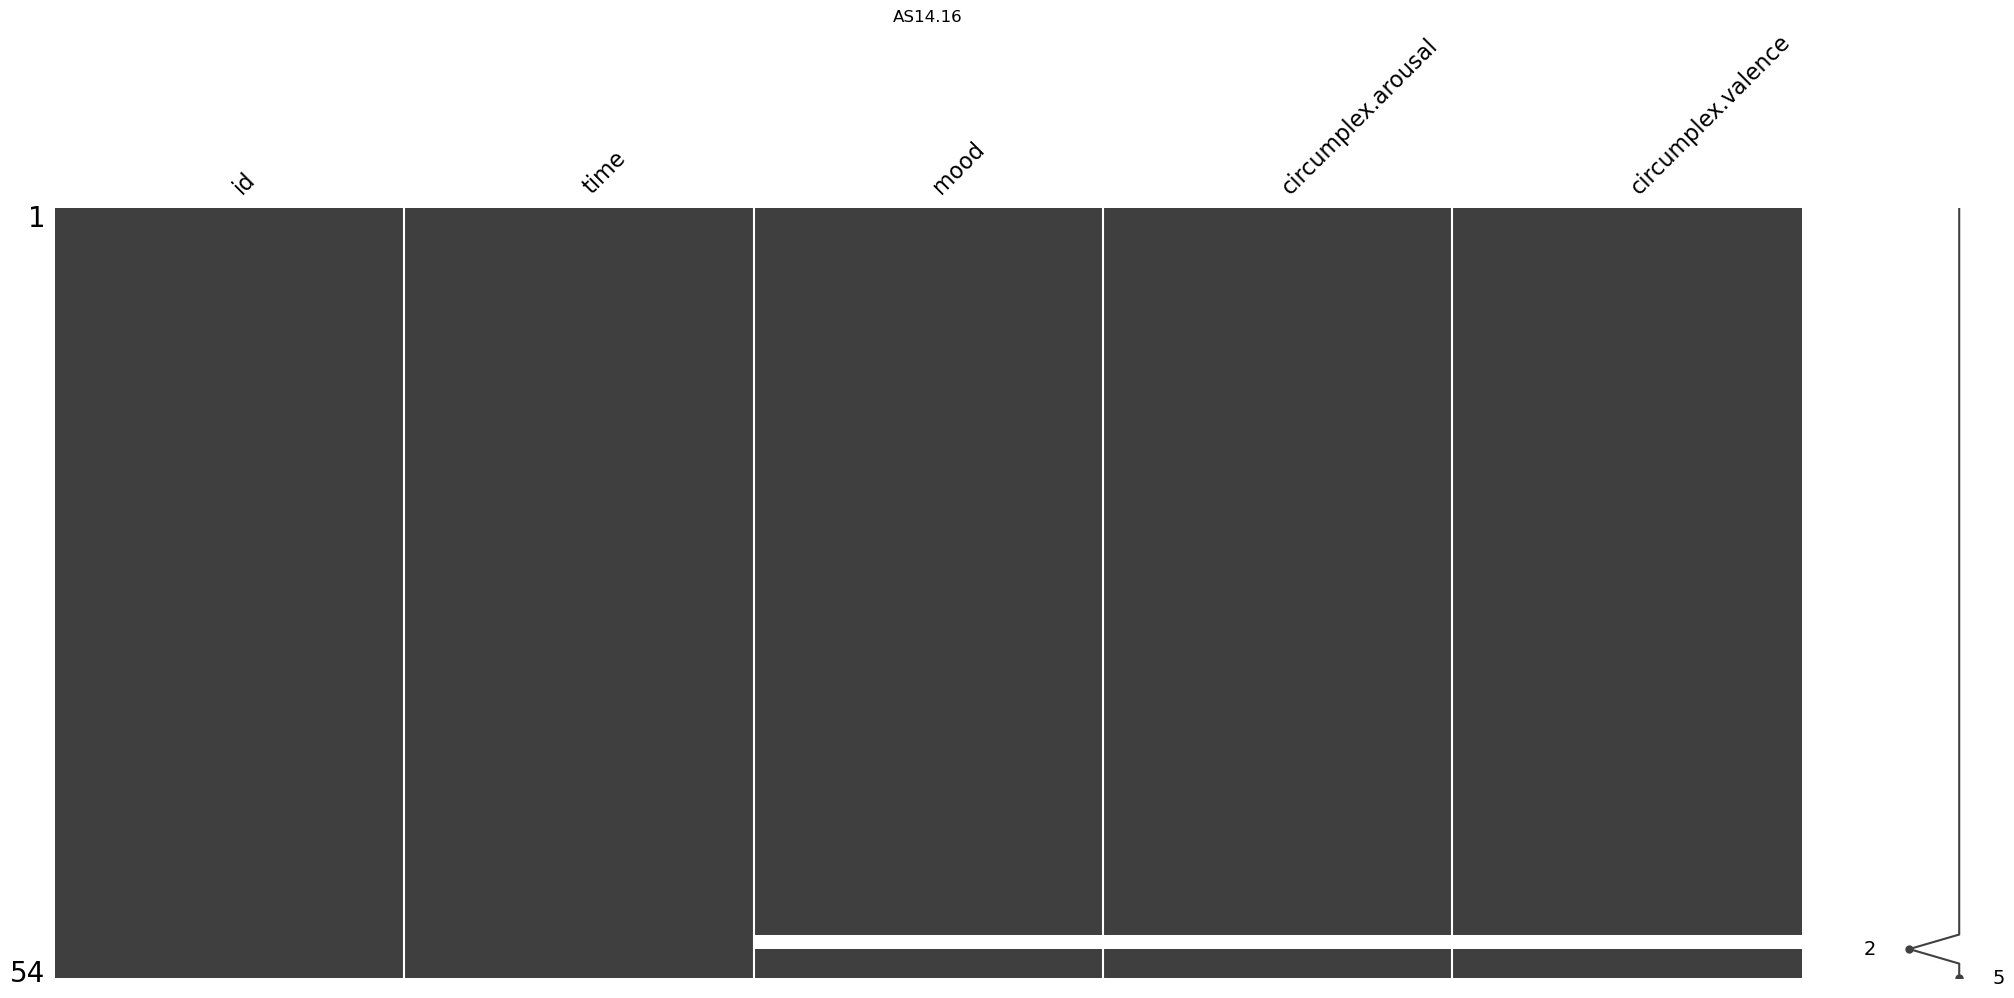

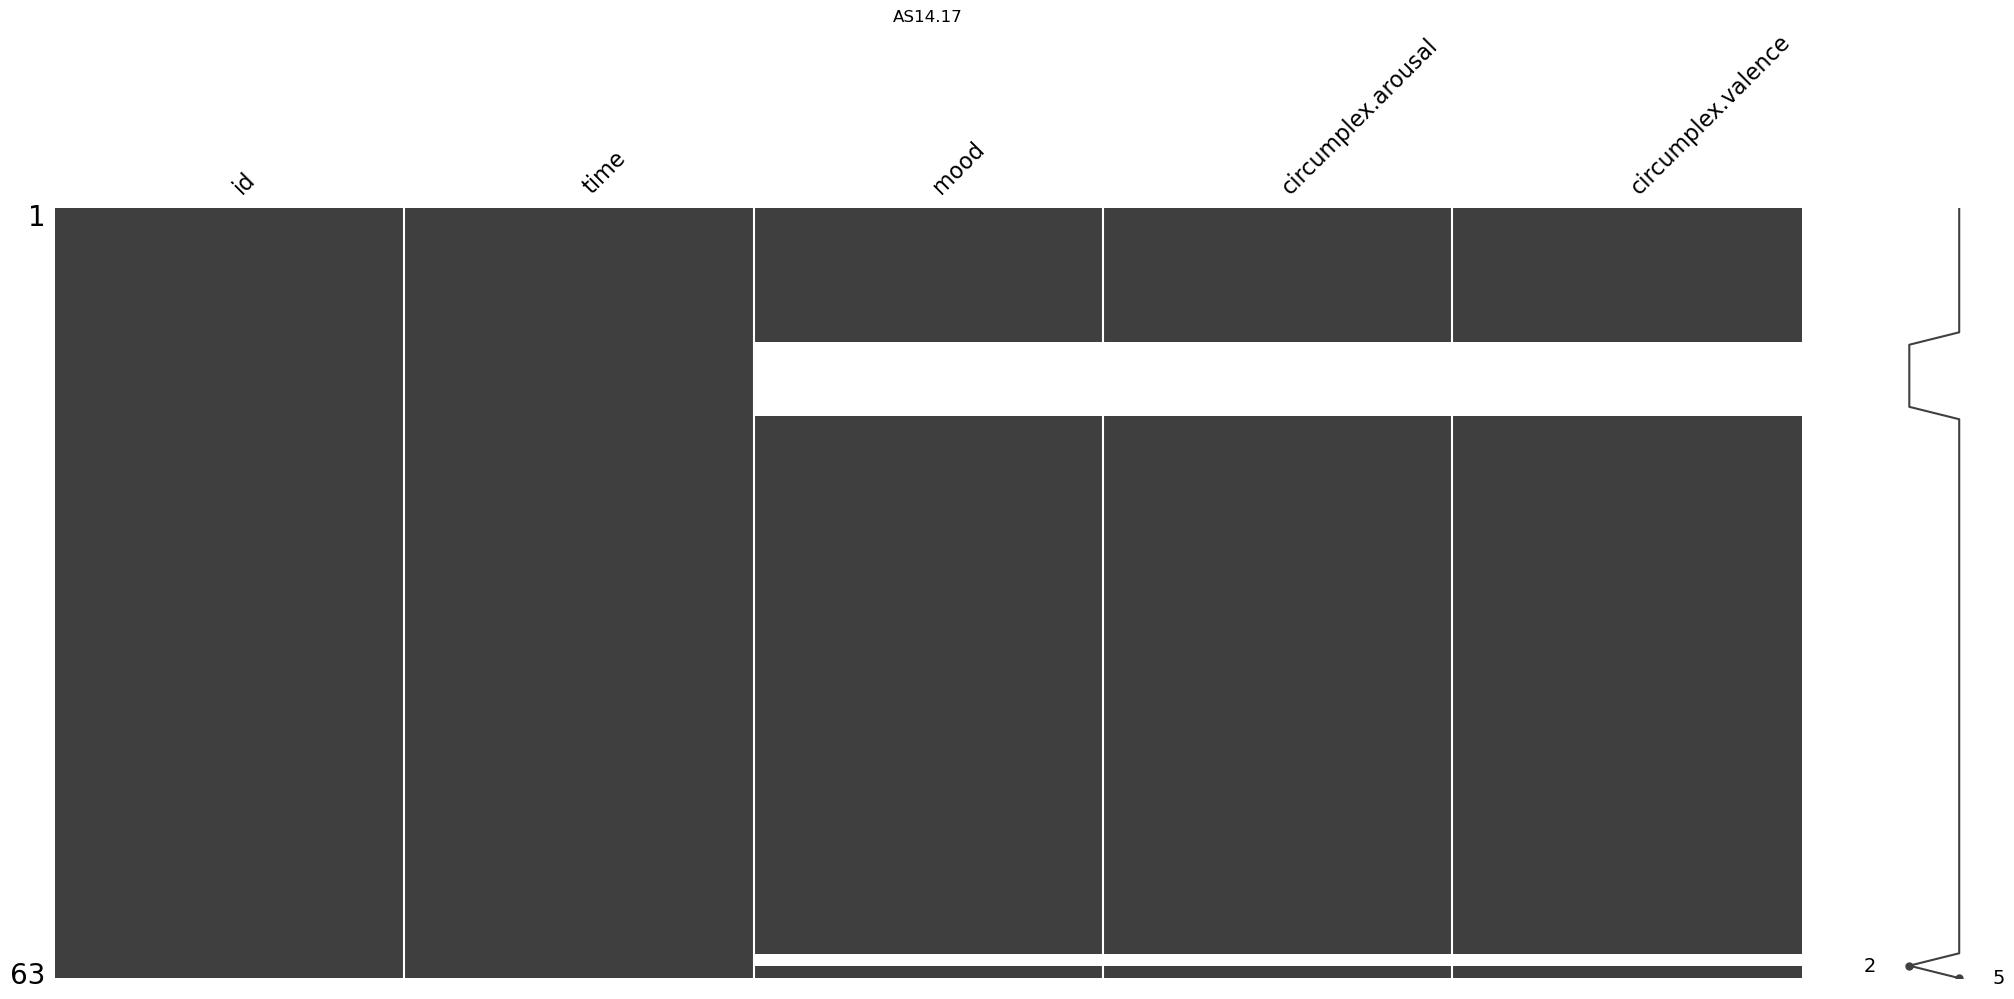

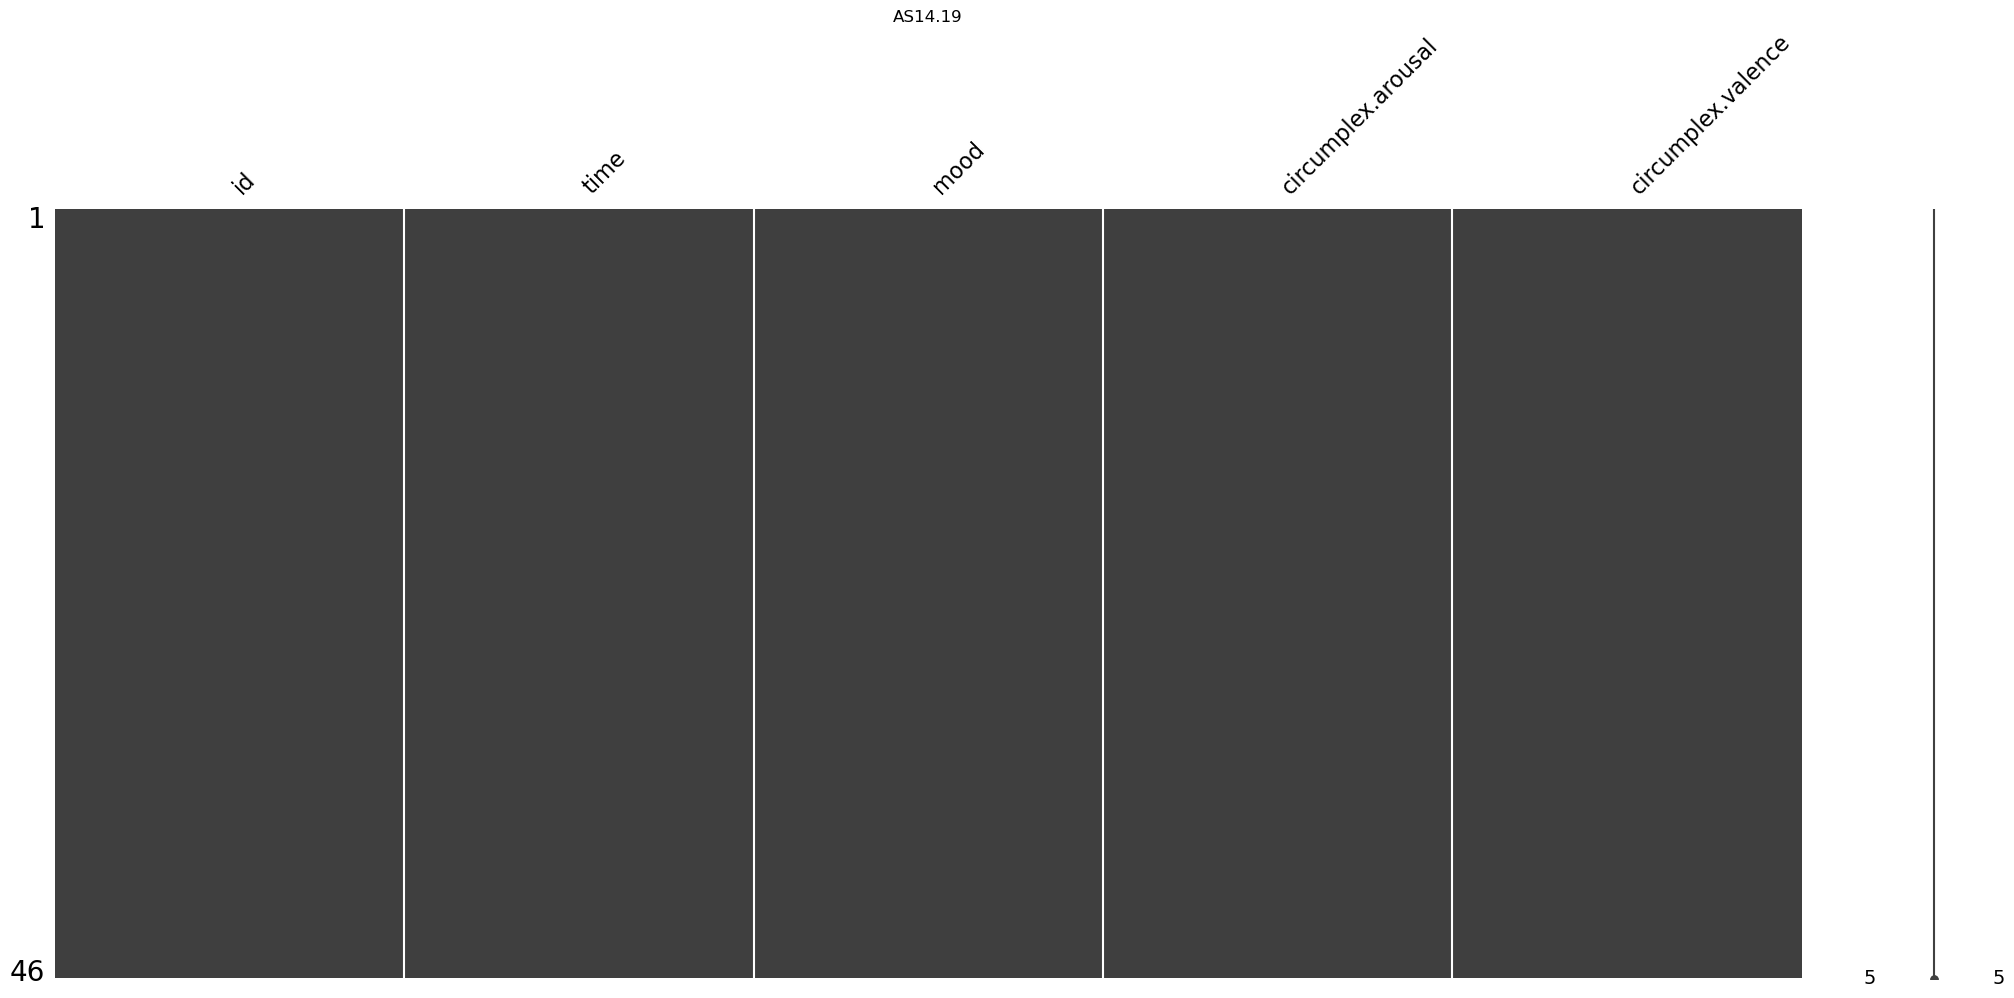

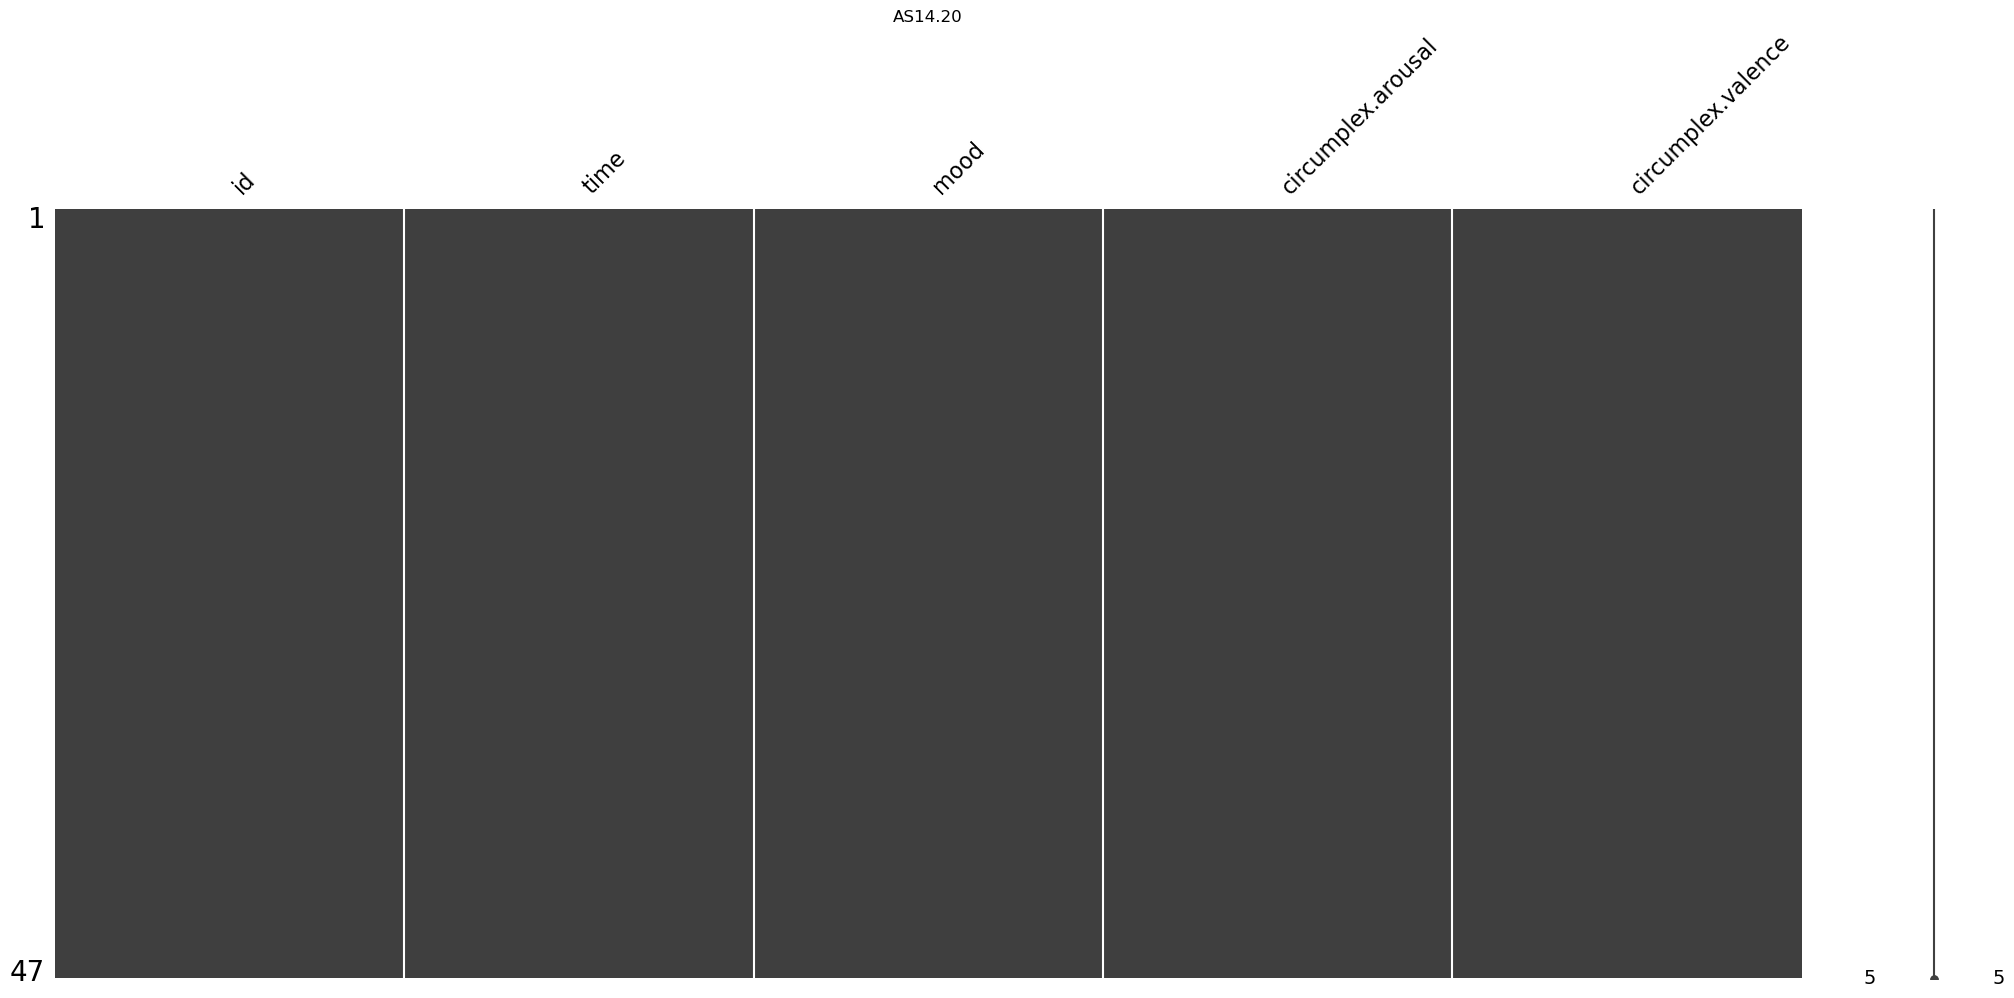

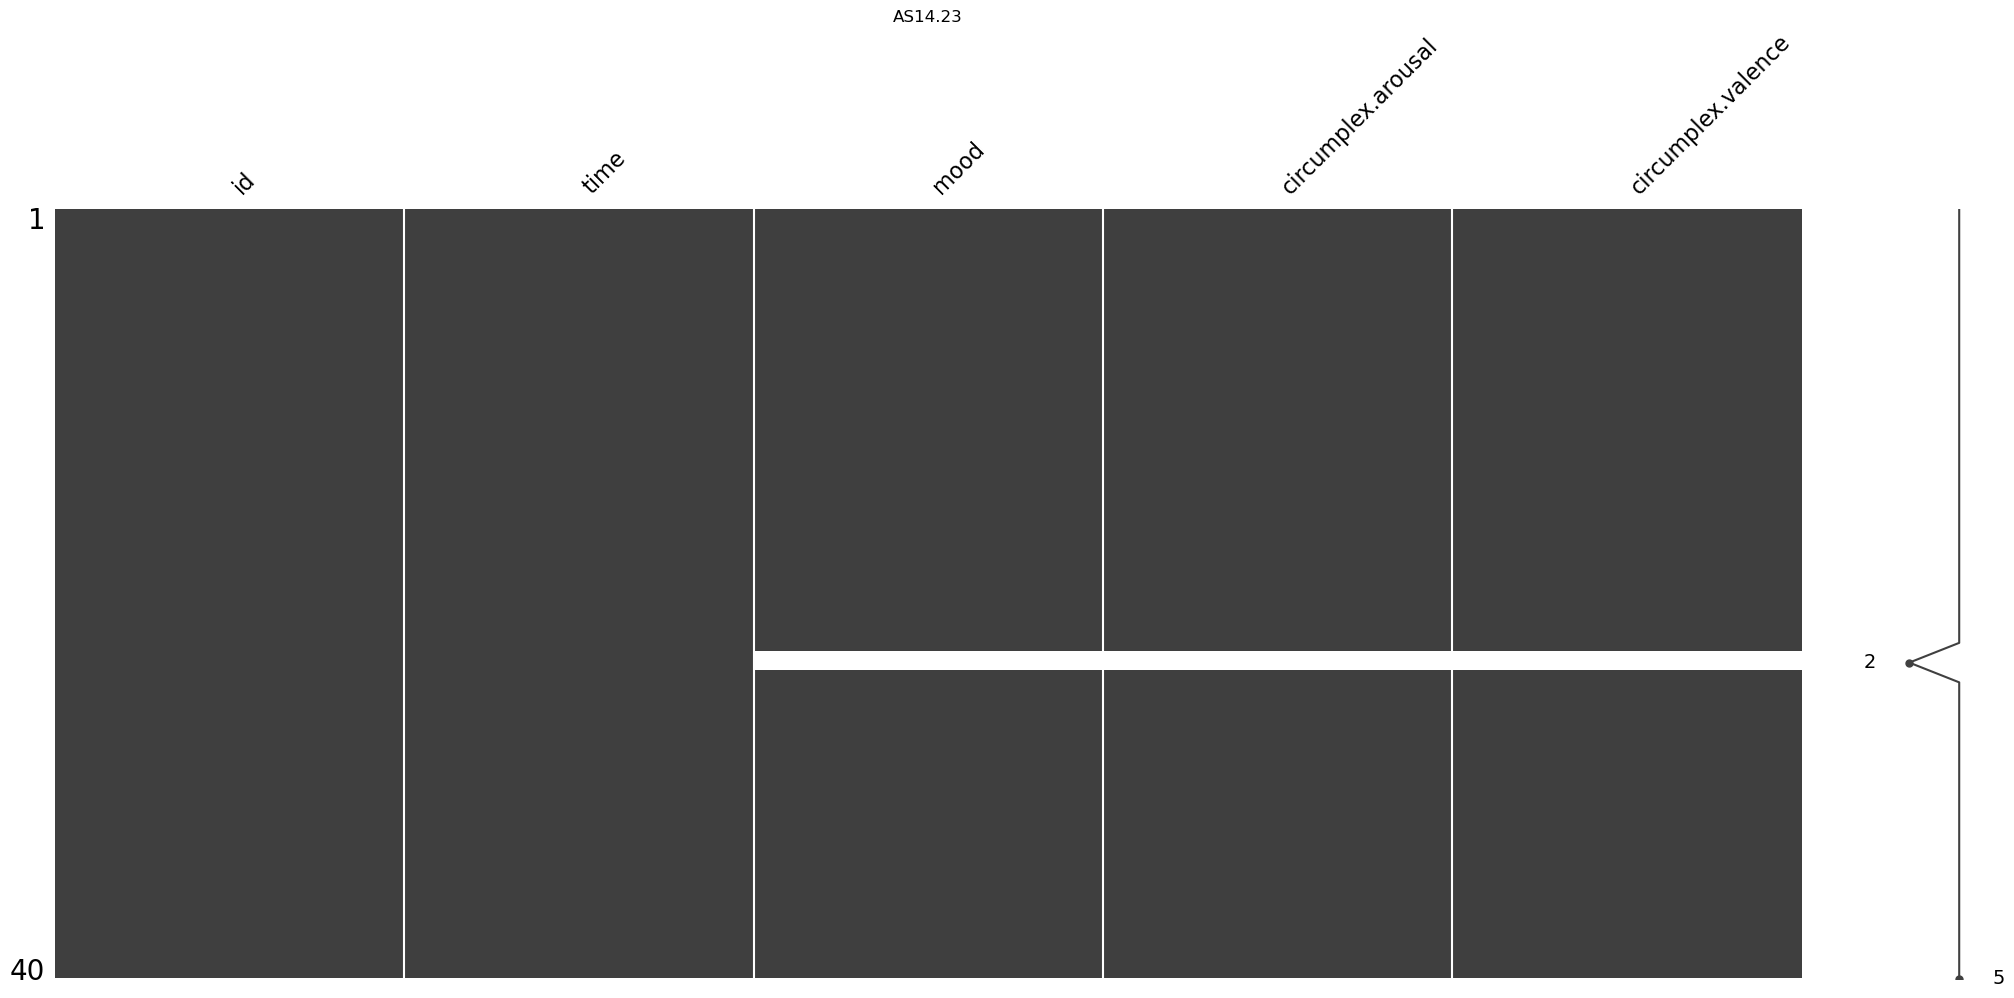

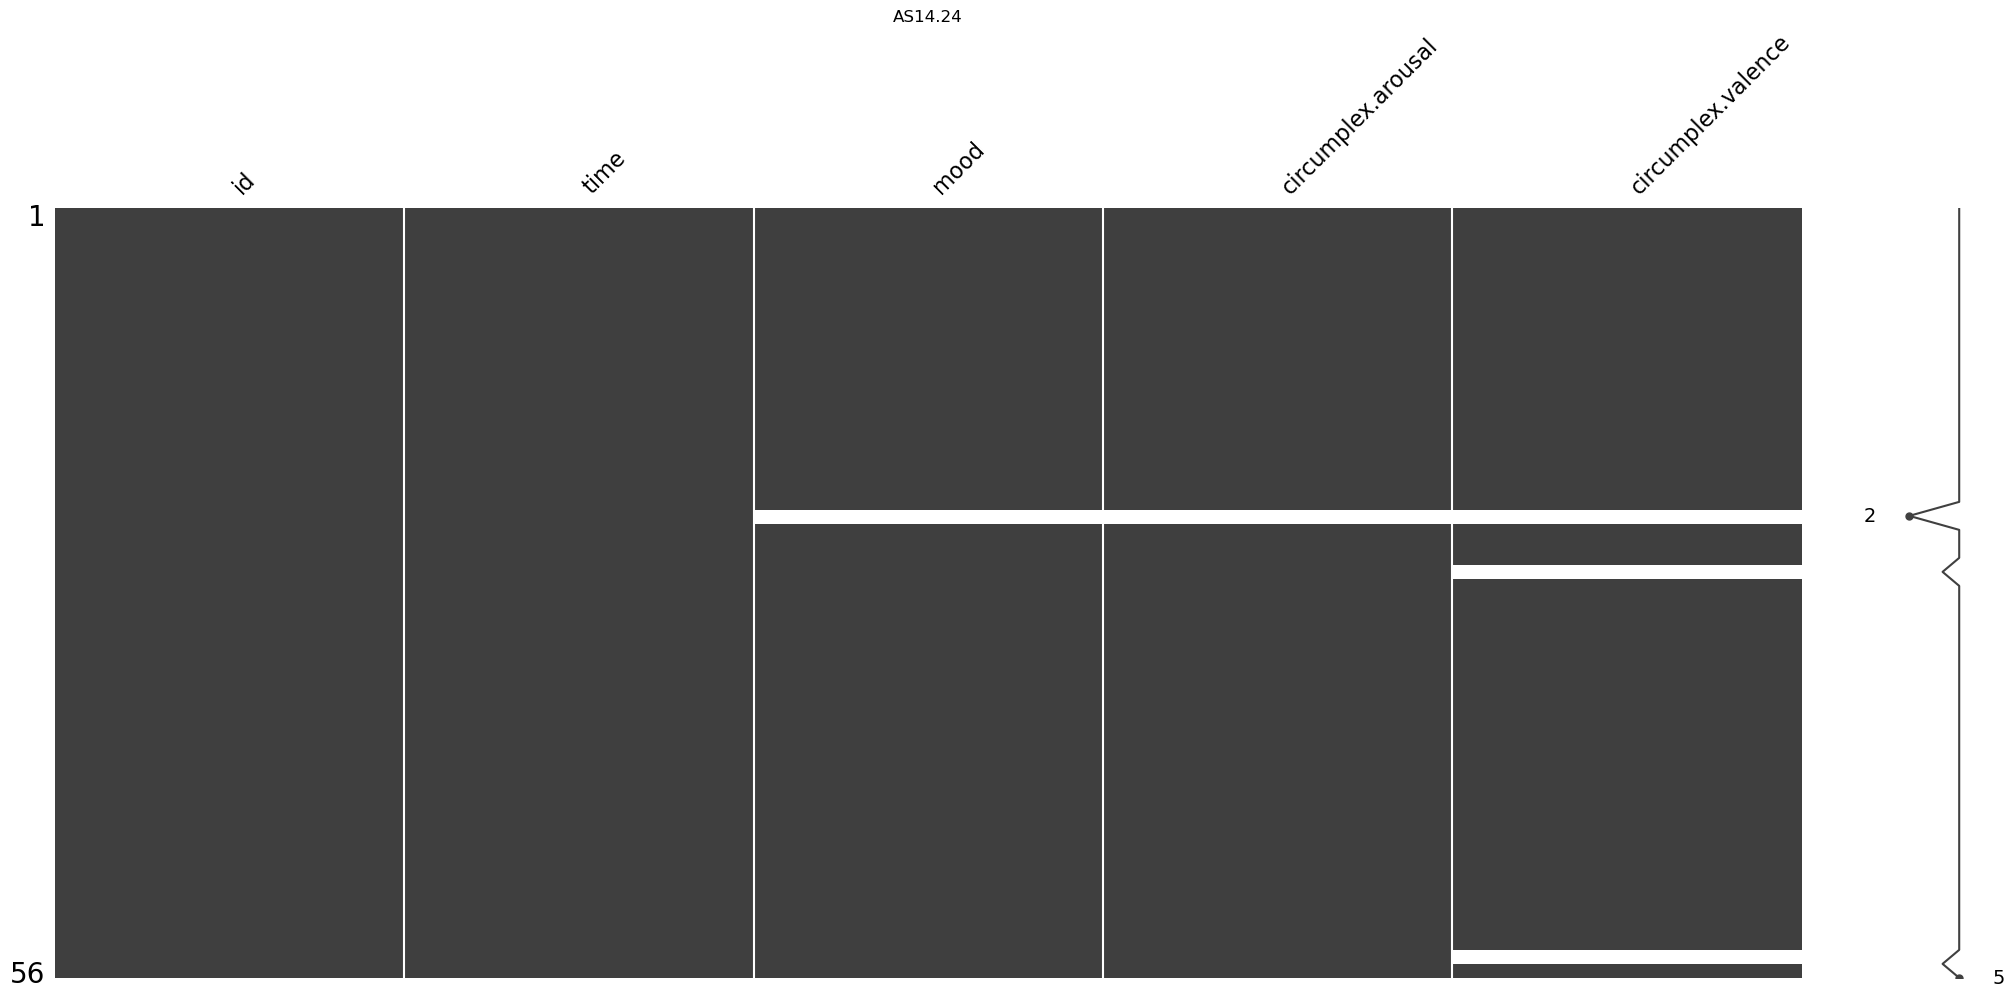

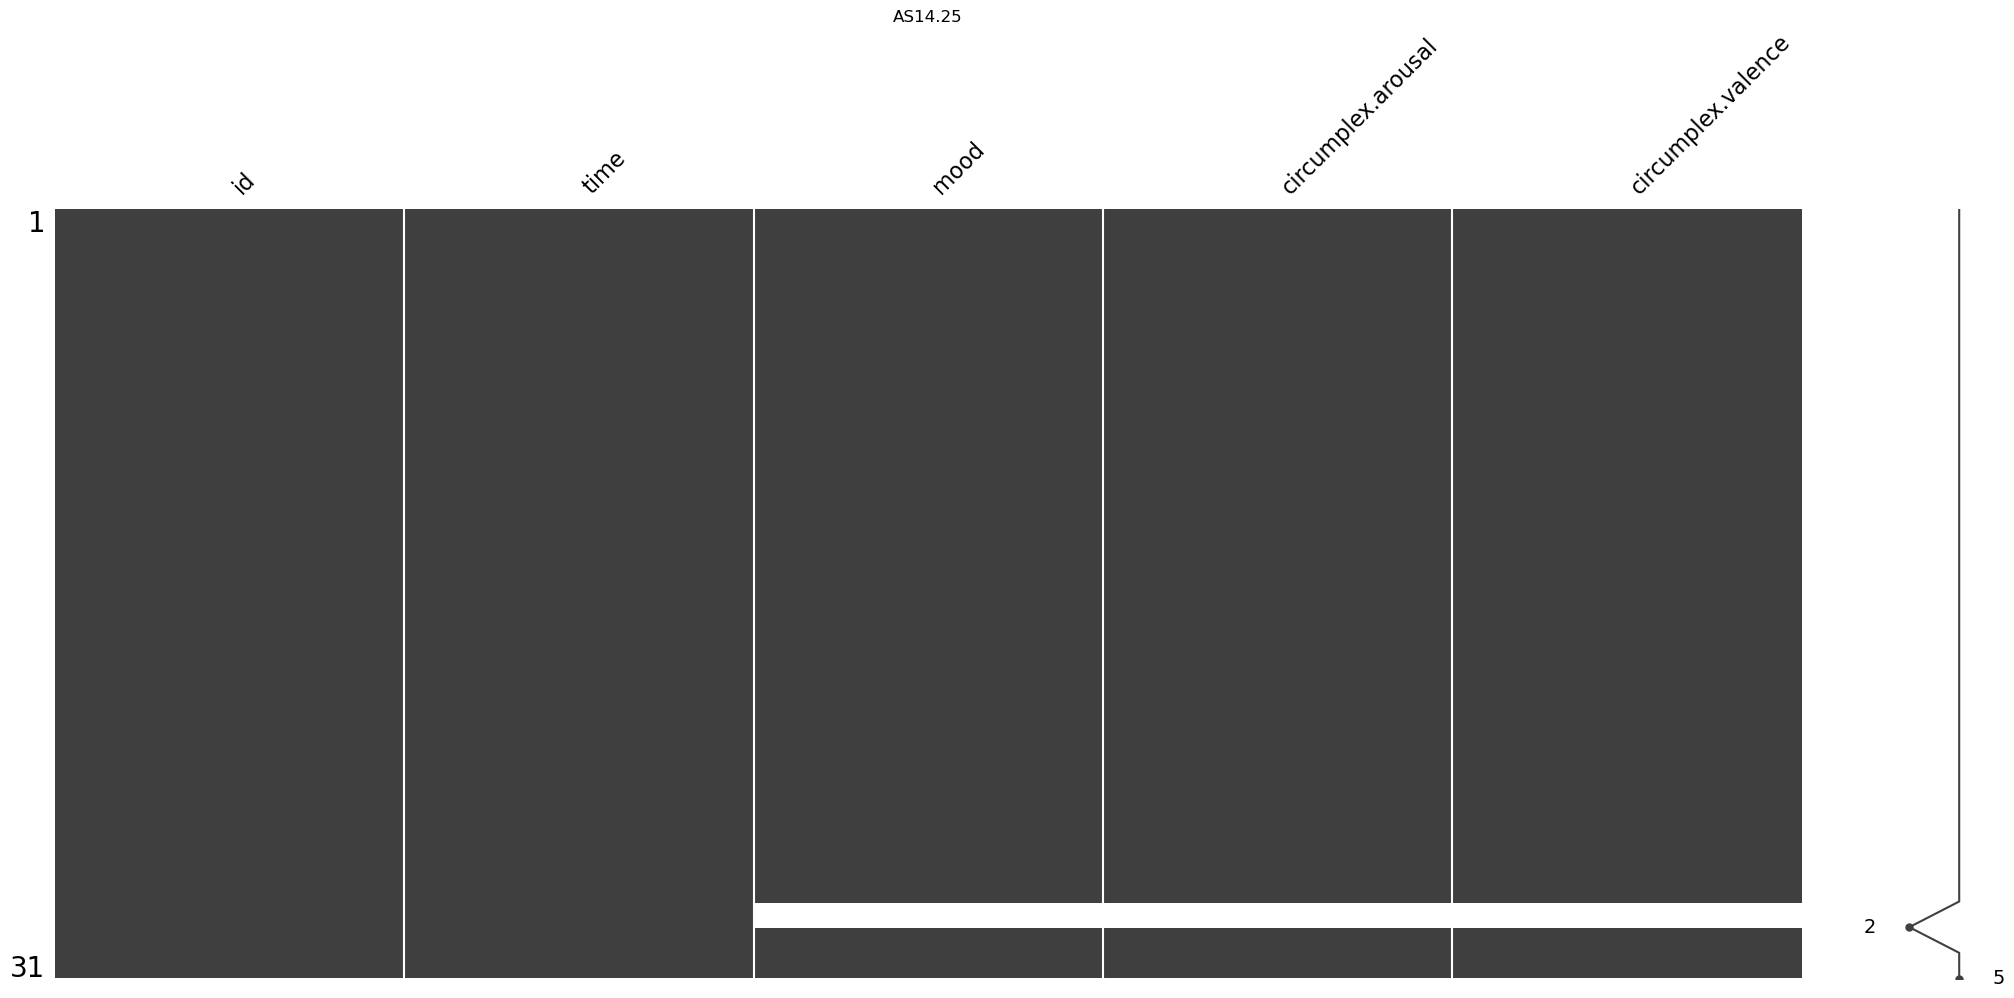

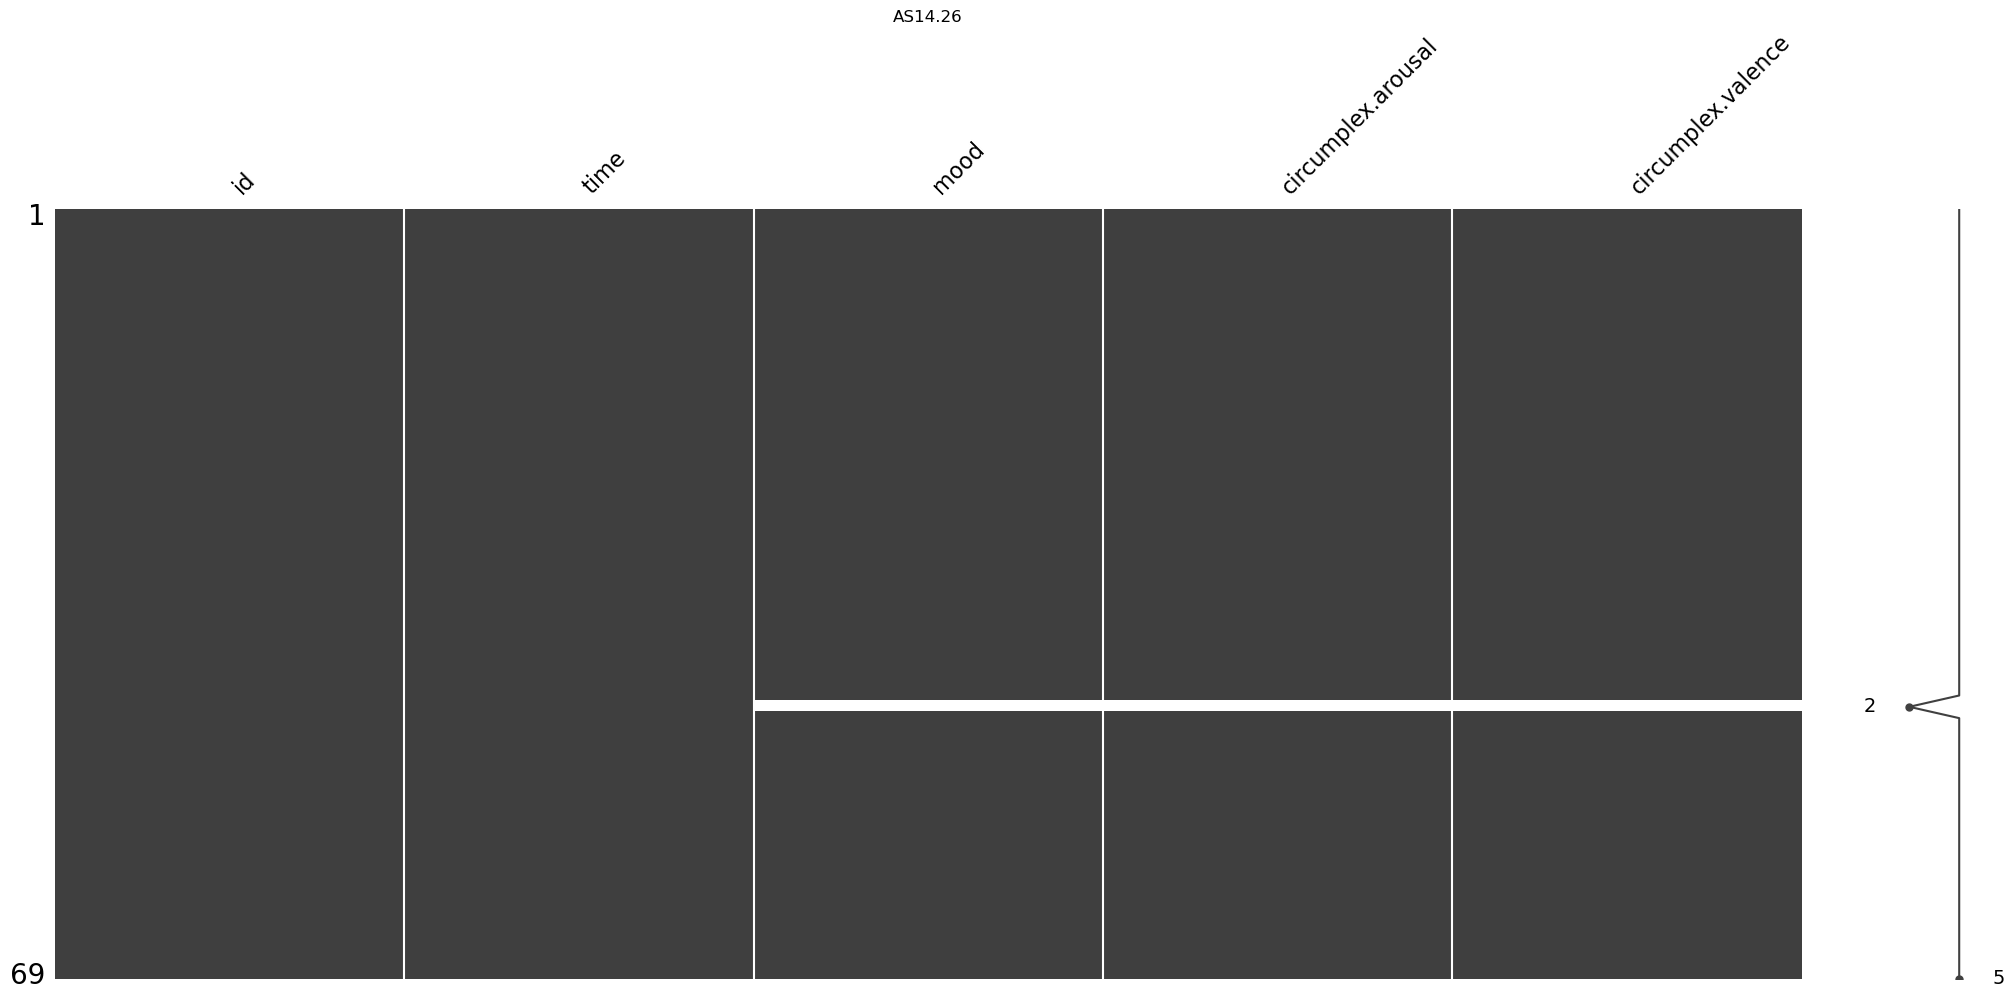

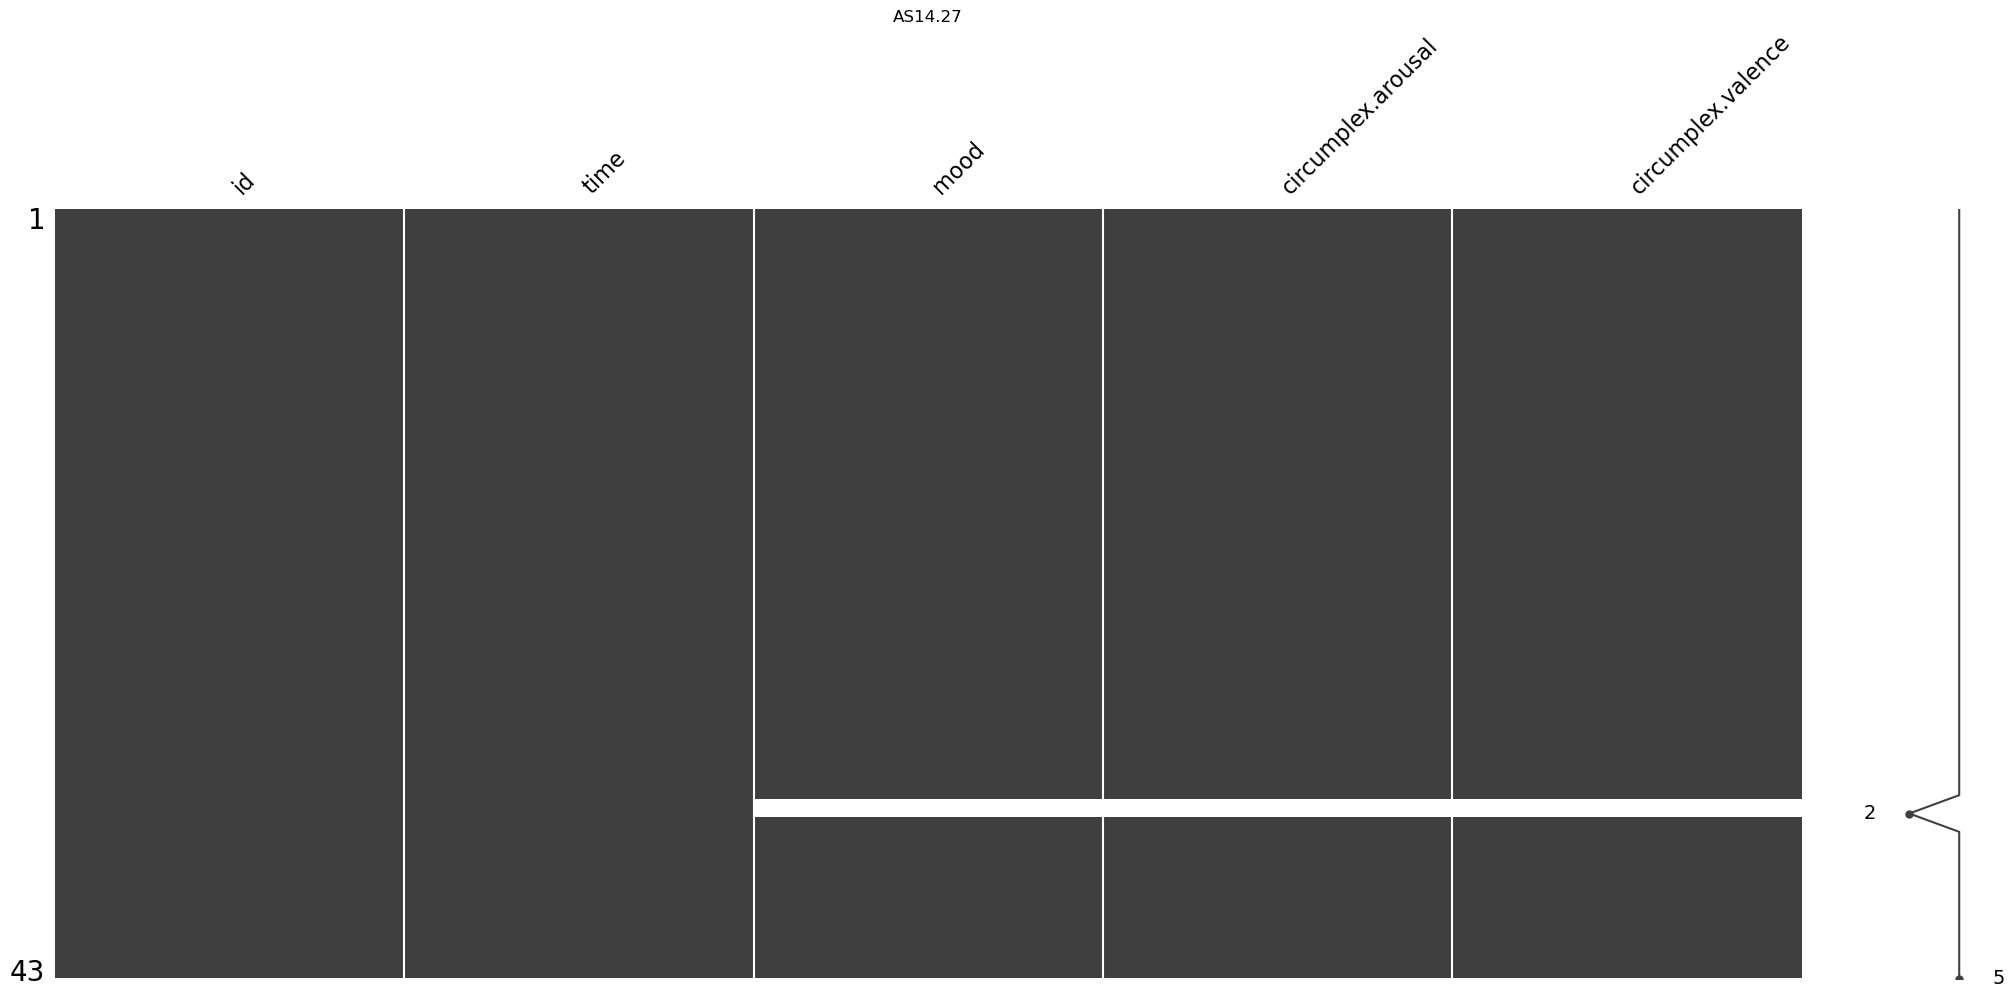

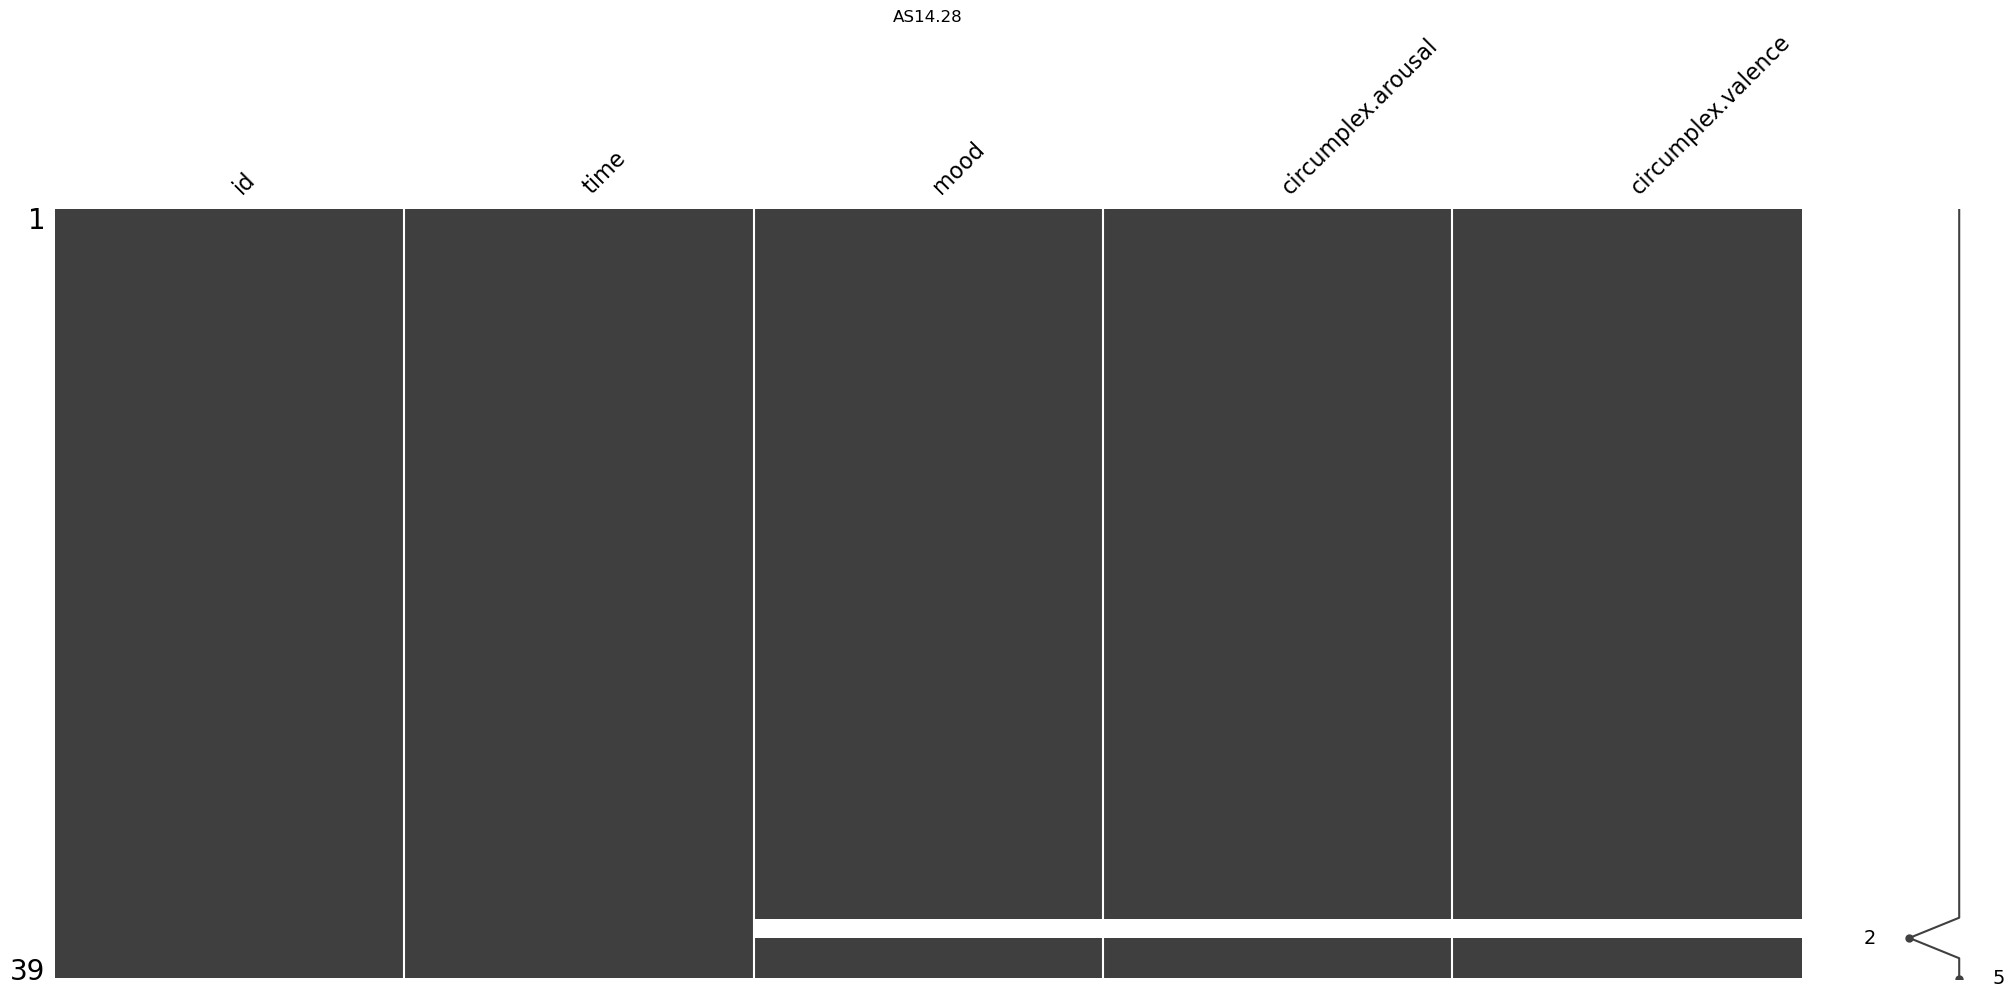

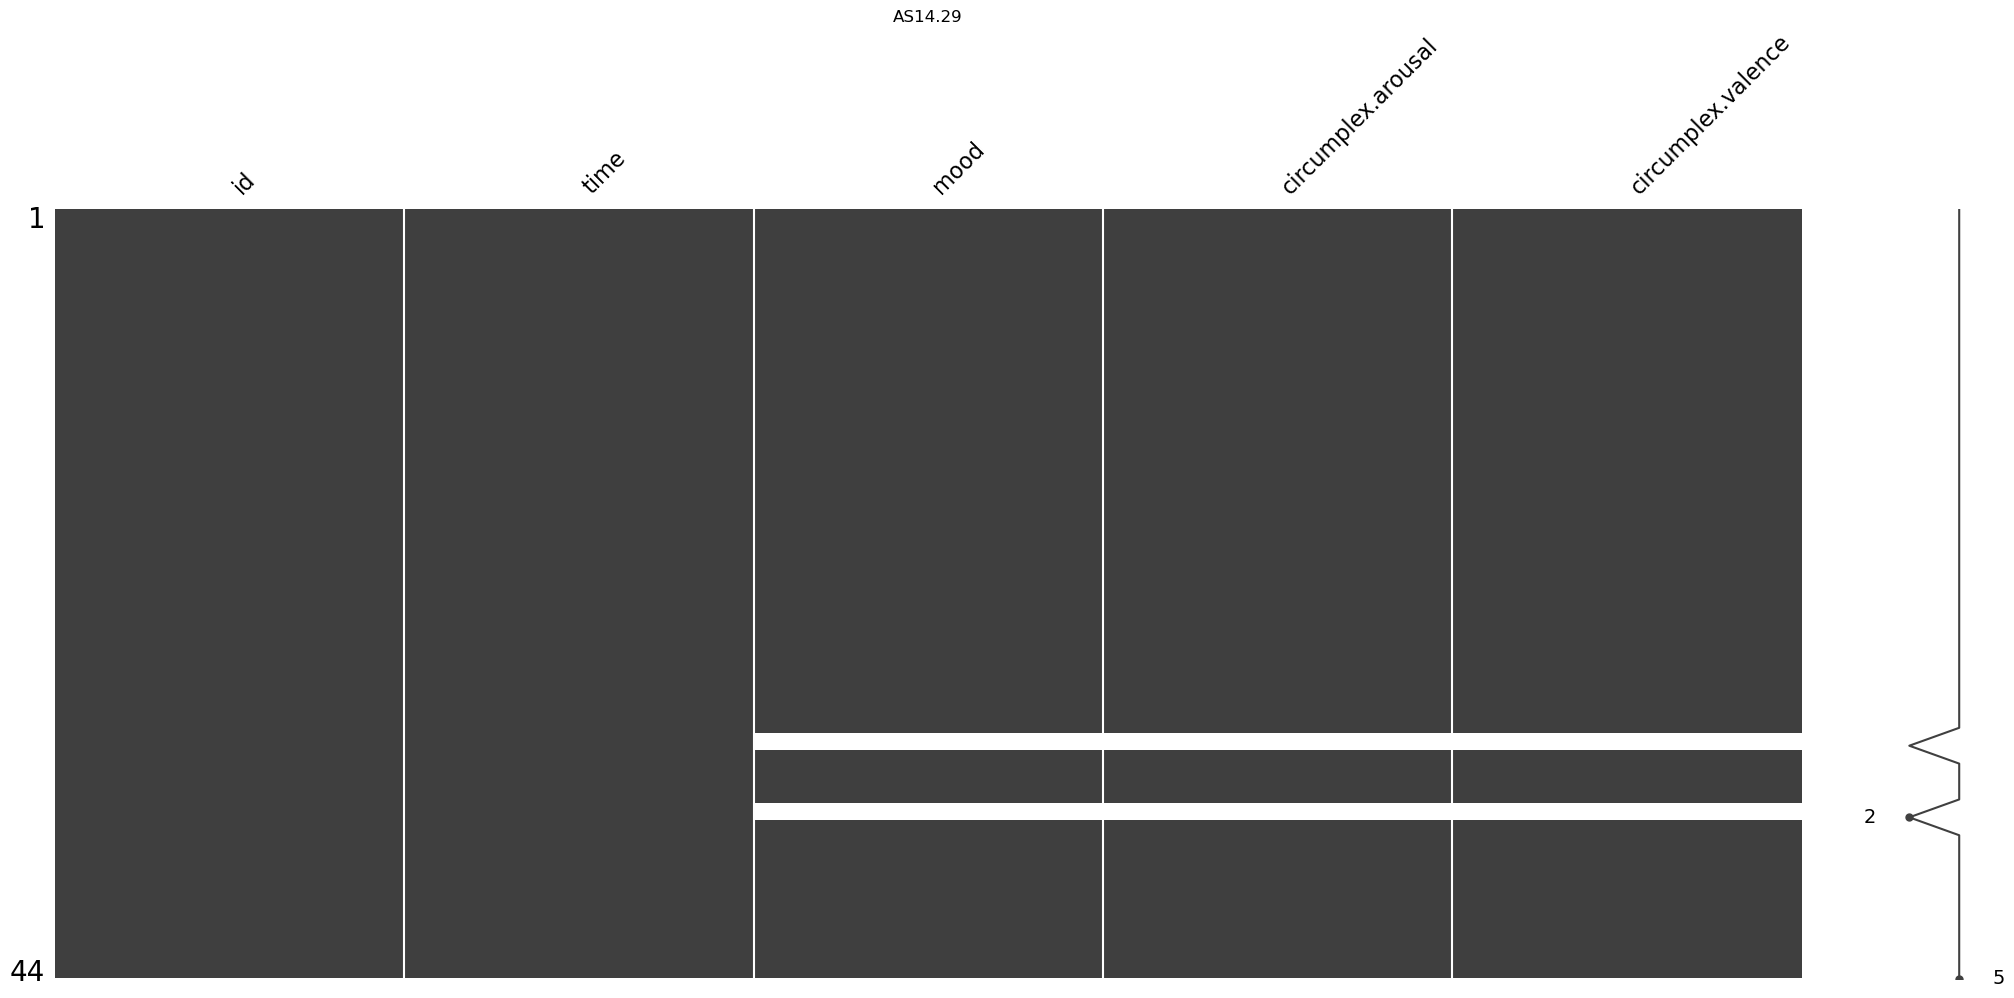

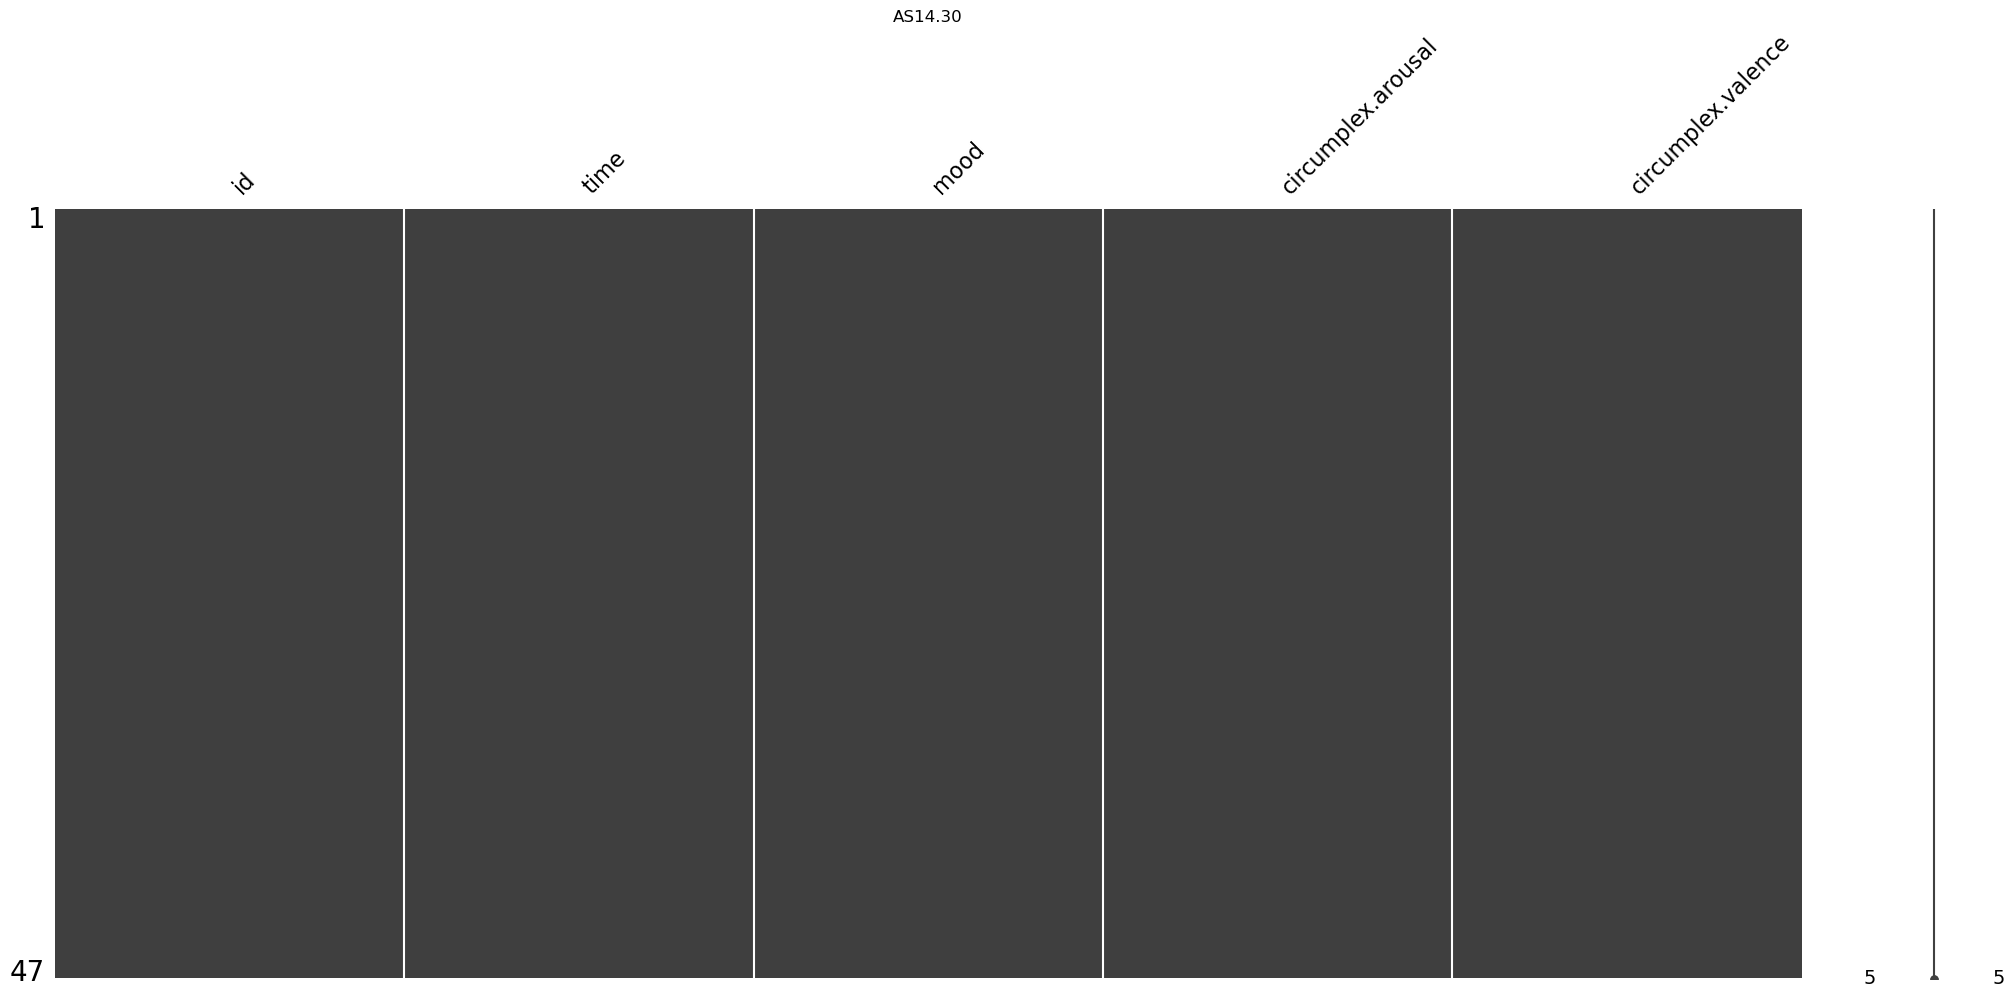

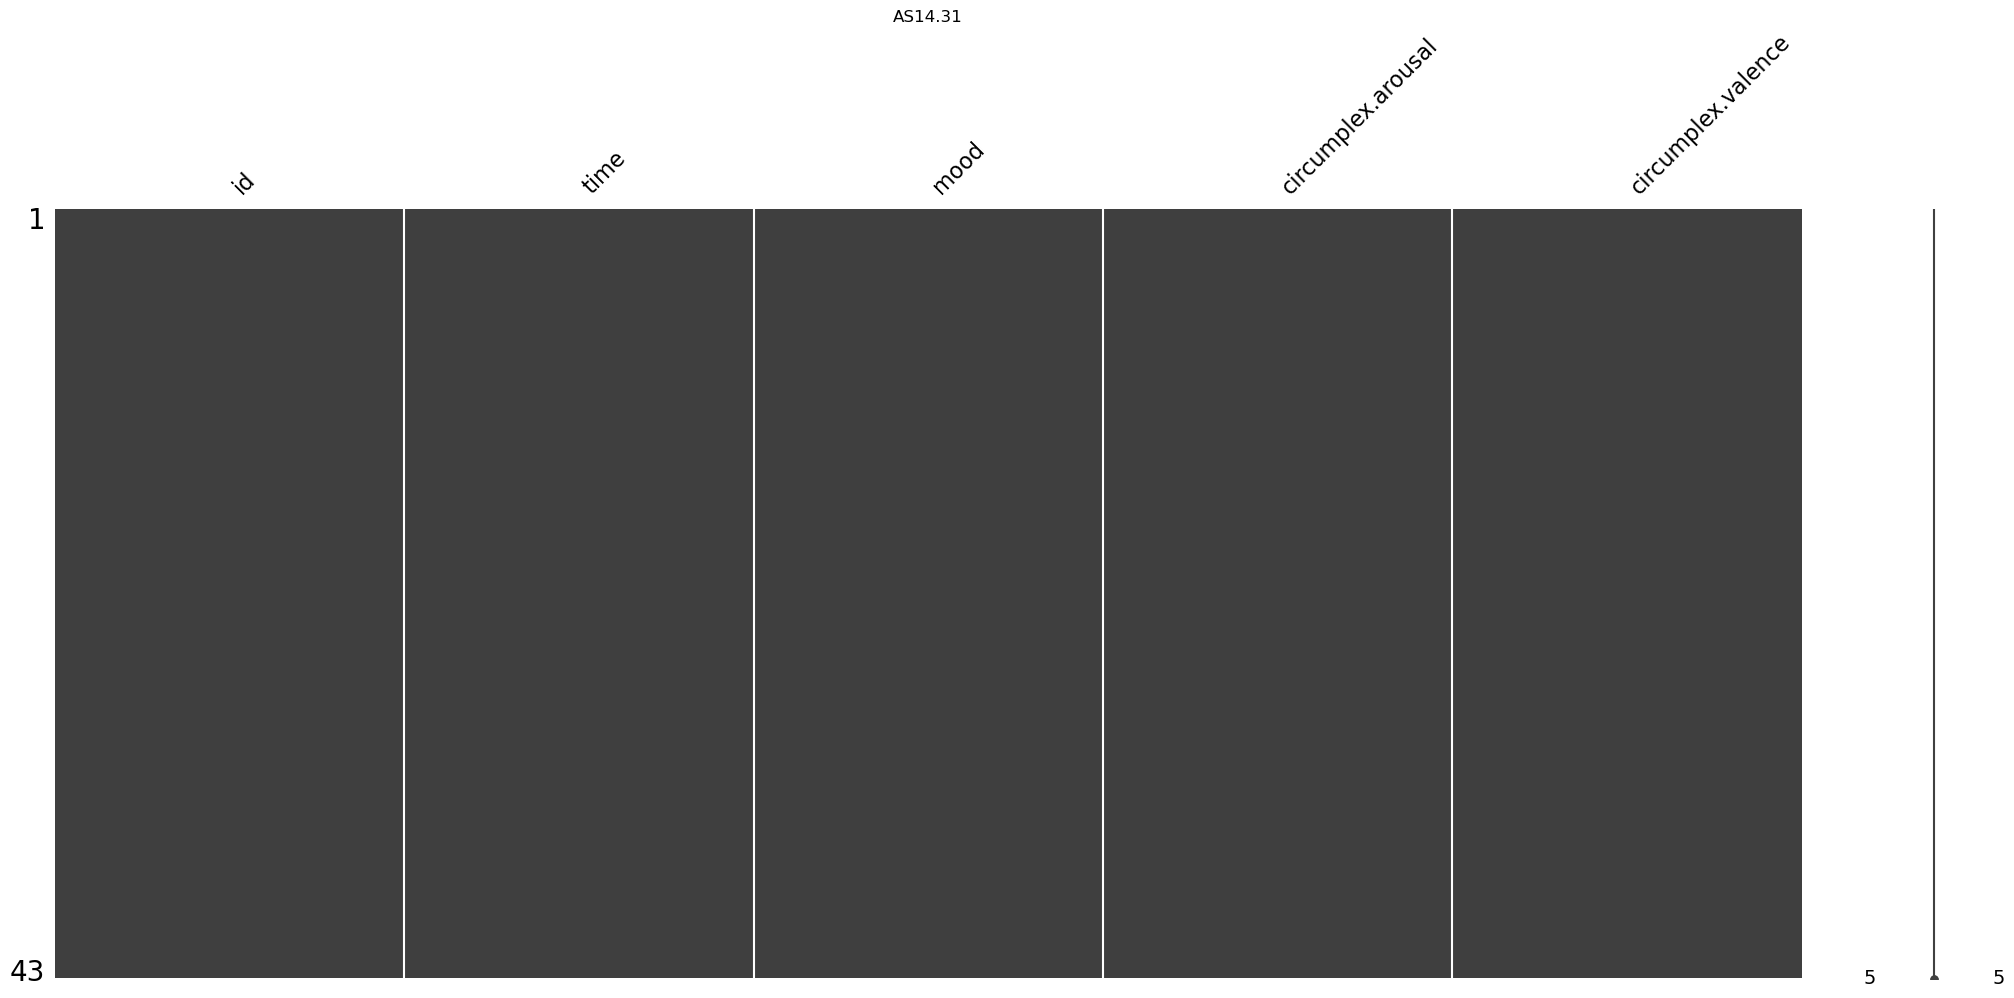

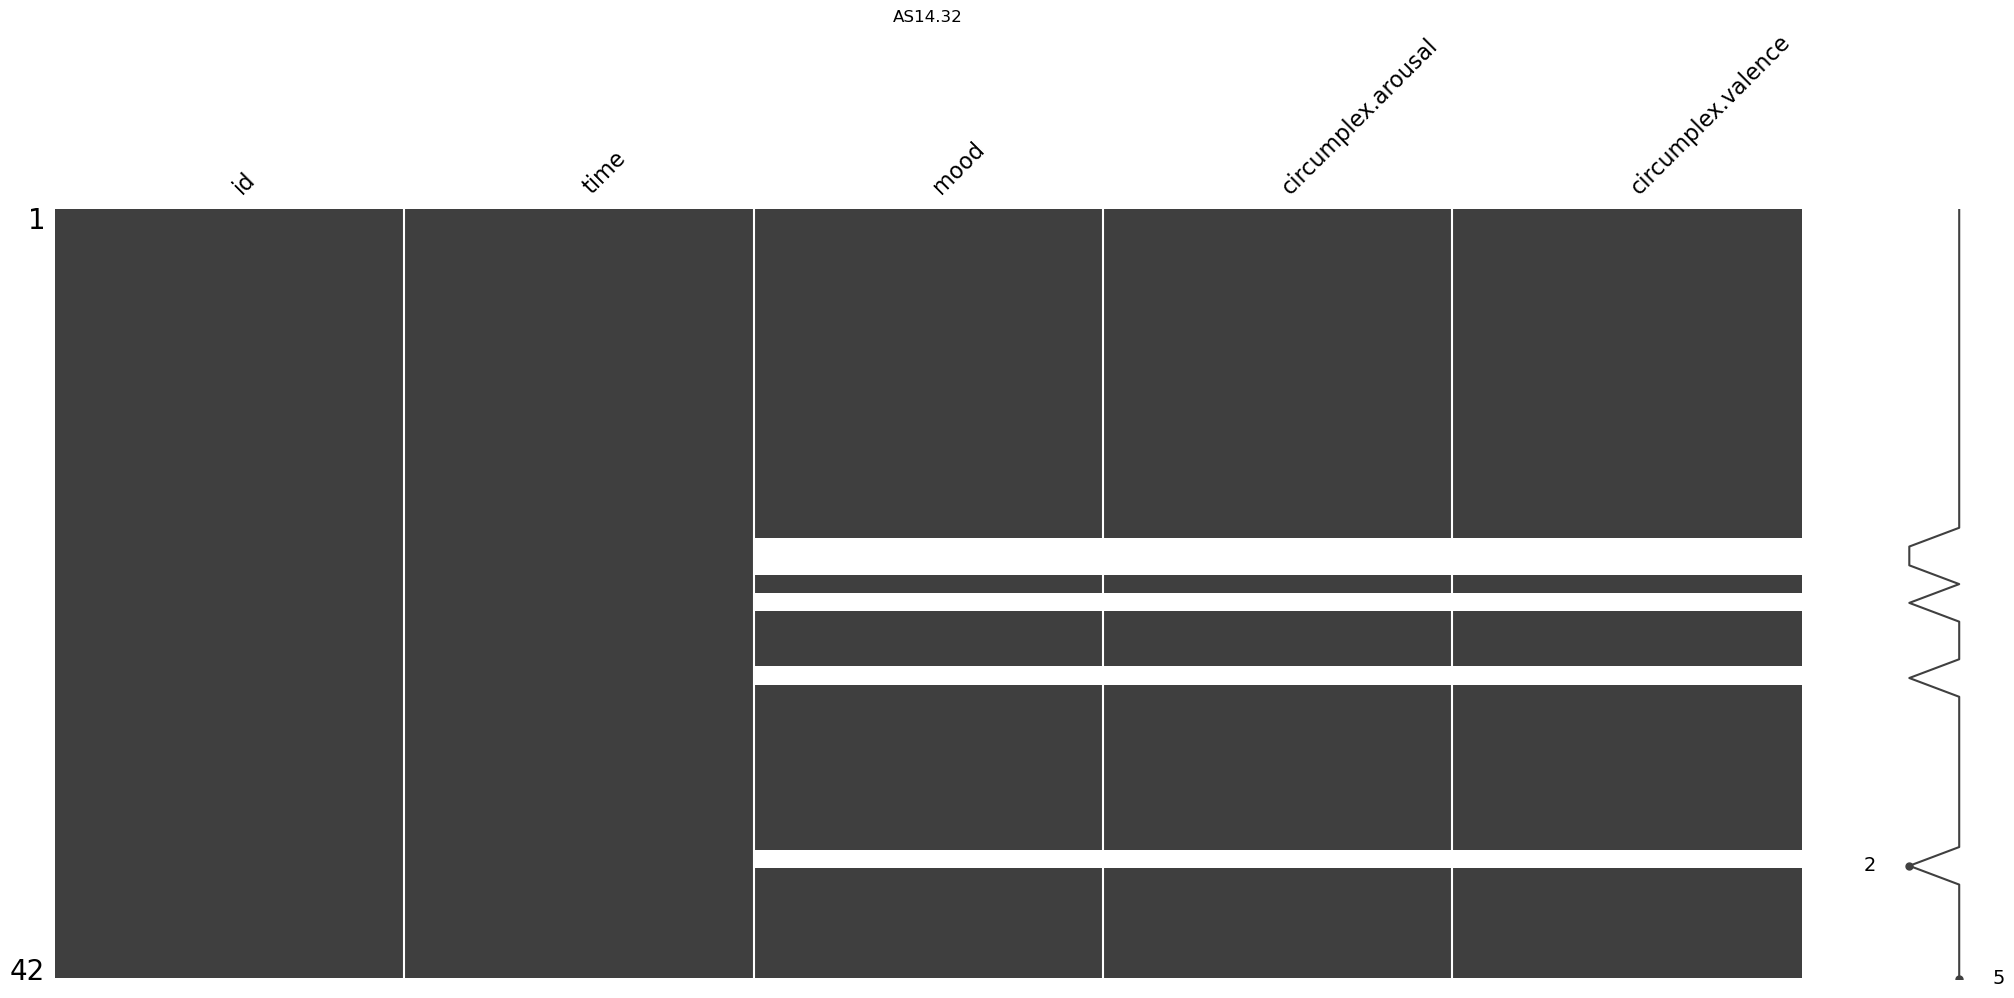

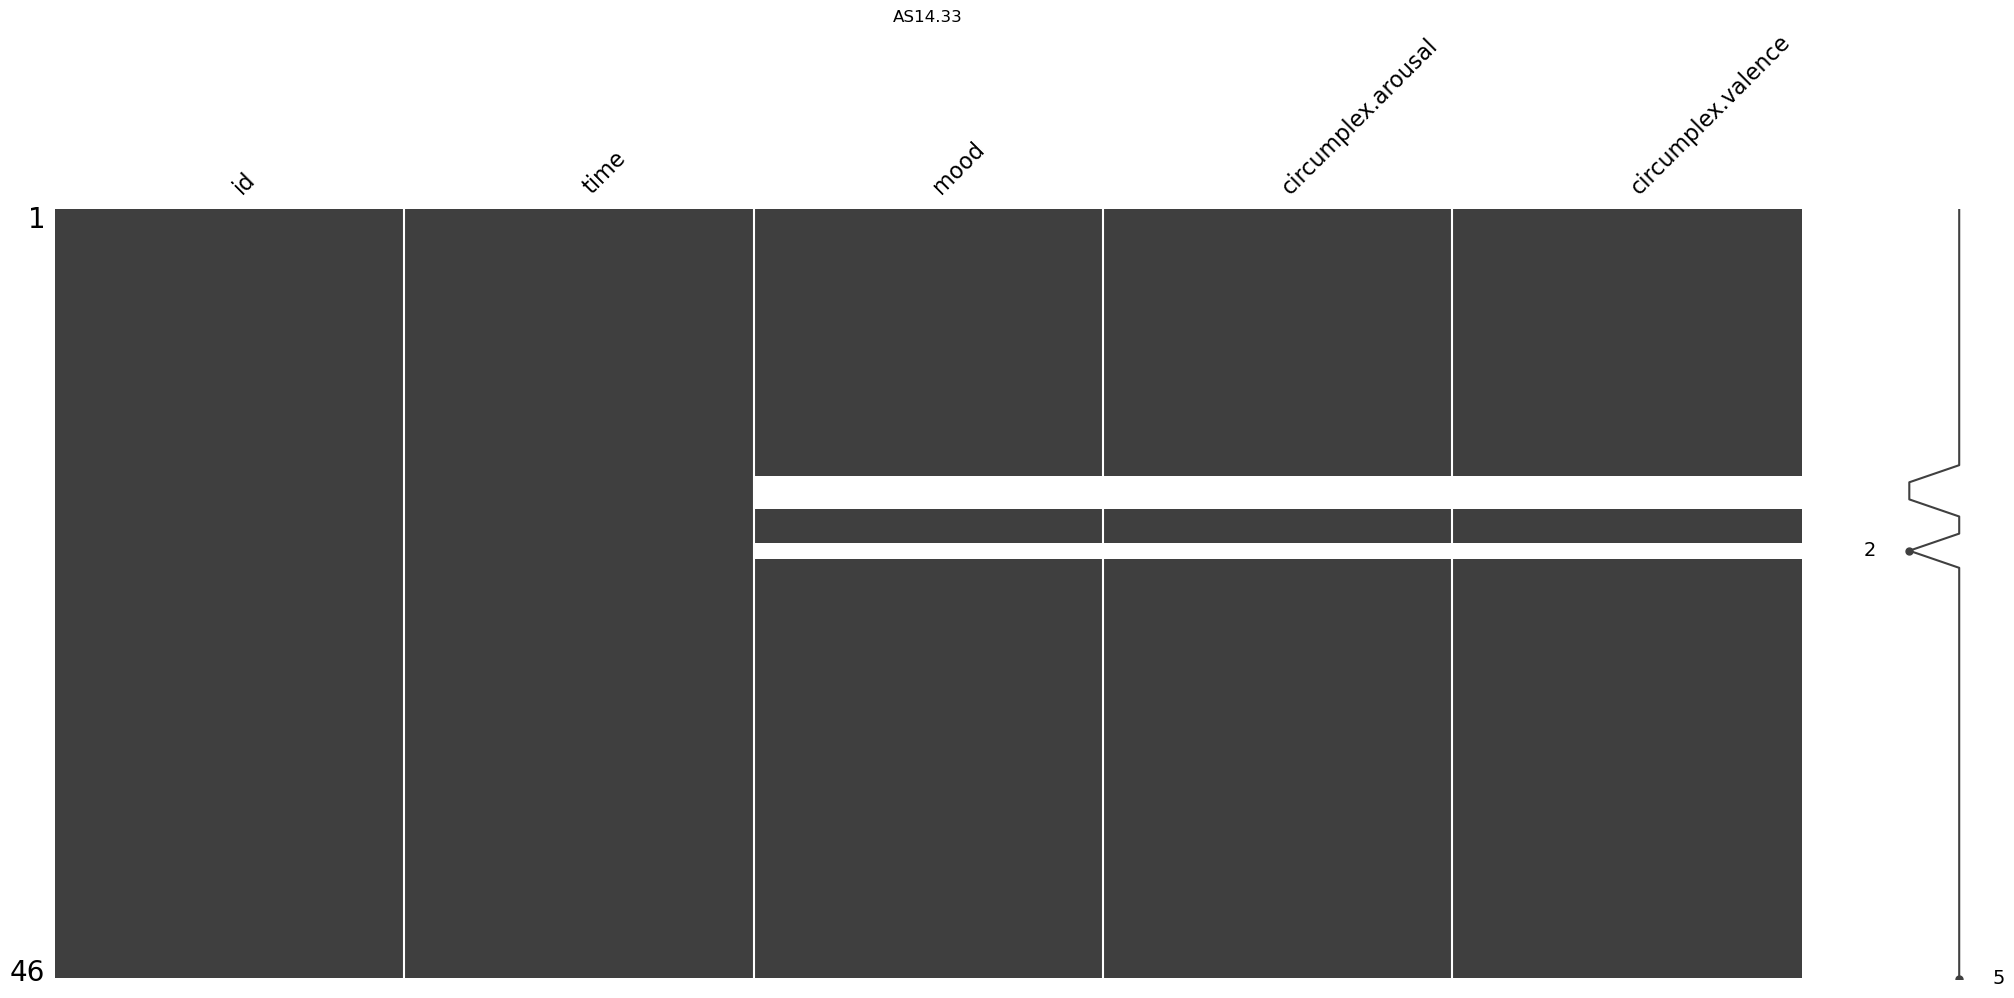

In [11]:
# check for missing data
import missingno as msno
import matplotlib.pyplot as plt


for id in user_ids:
    to_plot = trimmed[["id", "time", "mood", "circumplex.arousal", "circumplex.valence"]]
    # if you want to see difference before trimming uncomment line below
    # to_plot = filled_df[["id", "time", "mood", "circumplex.arousal", "circumplex.valence"]]
    msno.matrix(to_plot[to_plot['id'] == id])
    plt.title(id)

In [12]:
# data looks good after trimming and seems ready for imputing
# ... apart from AS14.01
AS14_01_data = trimmed[trimmed["id"] == "AS14.01"]
AS14_01_data.head(30)
# we can observe that there is a big period of missing data that ends on 2014-03-21
# therefore we are going to drop all data before this date for user AS14.01
date = "2014-03-21"
AS14_01_data = AS14_01_data[AS14_01_data["time"] >= pd.Timestamp(date)].reset_index(drop=True)
AS14_01_data.head(10)
trimmed = trimmed[trimmed["id"] != "AS14.01"]
trimmed = pd.concat([AS14_01_data, trimmed])
trimmed.reset_index(drop=True, inplace=True)
trimmed.head()


/var/folders/vc/x7syt19d4lb1zp__5l59vrnm0000gn/T/ipykernel_5872/3406403251.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  AS14_01_data = AS14_01_data[AS14_01_data["time"] >= pd.Timestamp(date)].reset_index(drop=True)


variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,circumplex.arousal,circumplex.valence,mood
0,AS14.01,2014-03-21,2.804671,2294.74210,6281.06000,1007.456,49.544,0.0,169.1337,239.751,...,861.09728,0.00000,489.48354,0.000,6.0,16592.655540,0.0,0.2,0.2,6.20
1,AS14.01,2014-03-22,3.790084,604.52826,4962.91800,93.324,21.076,0.0,0.0000,98.143,...,37.30500,0.00000,117.62100,0.000,3.0,6142.285220,1.0,0.6,0.5,6.40
2,AS14.01,2014-03-23,2.141117,901.67892,4893.48424,94.346,43.403,0.0,0.0000,72.823,...,0.00000,0.00000,30.08600,30.386,0.0,6773.844221,0.0,0.2,0.8,6.80
3,AS14.01,2014-03-24,1.895065,867.05180,8380.17672,976.971,34.106,0.0,3.0100,66.558,...,409.16028,0.00000,171.96654,0.000,10.0,15047.635441,0.0,0.4,0.0,6.00
4,AS14.01,2014-03-25,2.360979,864.12106,8926.12772,68.206,43.054,0.0,0.0000,178.819,...,0.00000,221.40972,222.89300,0.000,0.0,16442.515079,1.0,0.5,0.5,6.75


#### Imputing missing data with KNN

In [14]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

df_knn = trimmed.drop(columns=['time', 'id'])
# data normalization, needed for KNN
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

df_knn_imputed = trimmed[['id', 'time']].join(df_knn_imputed)
# dataset is already normalized
df_knn_imputed.to_csv('knn_imputed_data.csv')
df_knn_imputed

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,screen,sms,circumplex.arousal,circumplex.valence,mood
0,AS14.01,2014-03-21,0.243295,0.447549,0.434987,0.119466,0.039790,0.0,0.035532,0.065960,...,0.326282,0.000000,0.272236,0.000000,0.193548,0.856057,0.000000,0.550000,0.420290,0.533333
1,AS14.01,2014-03-22,0.328776,0.117903,0.343701,0.011066,0.016927,0.0,0.000000,0.027001,...,0.014135,0.000000,0.065417,0.000000,0.096774,0.316896,0.058824,0.650000,0.516908,0.566667
2,AS14.01,2014-03-23,0.185734,0.175857,0.338892,0.011188,0.034858,0.0,0.000000,0.020035,...,0.000000,0.000000,0.016733,0.092875,0.000000,0.349480,0.000000,0.550000,0.613527,0.633333
3,AS14.01,2014-03-24,0.164390,0.169103,0.580359,0.115851,0.027391,0.0,0.000632,0.018311,...,0.155037,0.000000,0.095643,0.000000,0.322581,0.776345,0.000000,0.600000,0.355878,0.500000
4,AS14.01,2014-03-25,0.204806,0.168532,0.618168,0.008088,0.034578,0.0,0.000000,0.049196,...,0.000000,0.088728,0.123966,0.000000,0.000000,0.848311,0.058824,0.625000,0.516908,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,AS14.33,2014-05-27,0.026449,0.108410,0.143937,0.014786,0.000000,0.0,0.000000,0.039256,...,0.000000,0.000000,0.031242,0.000000,0.032258,0.211007,0.117647,0.350000,0.484702,0.533333
1298,AS14.33,2014-05-28,0.215064,0.450578,0.134137,0.072893,0.000000,0.0,0.073920,0.142791,...,0.000000,0.000000,0.017056,0.000000,0.322581,0.656190,0.058824,0.500000,0.742351,0.866667
1299,AS14.33,2014-05-29,0.352581,0.078020,0.030133,0.016215,0.000000,0.0,0.000000,0.008034,...,0.000356,0.000000,0.001779,0.000000,0.161290,0.177519,0.058824,0.166667,0.677939,0.666667
1300,AS14.33,2014-05-30,0.350574,0.500611,0.115712,0.030857,0.000000,0.0,0.000000,0.014474,...,0.398864,0.003259,0.118875,0.000000,0.129032,0.490007,0.000000,0.300000,0.227053,0.633333


In [ ]:
import matplotlib.pyplot as plt
df_clean.id.value_counts().plot(kind="bar")
plt.title("General value counts per User (by ID)")
plt.xlabel("user ID")
plt.ylabel("count")
plt.show()

In [ ]:
df_clean.variable.value_counts().plot(kind="bar")
plt.title("General value counts per variable")
plt.xlabel("variable name")
plt.ylabel("count")
plt.show()

#### Plot timeseries function

can be used to plot all of the time series scatter plots at once
- y axis: values of a given variable
- x axis: time

In [ ]:
def plot_timeseries(df: pd.DataFrame, variable: str) -> None:
    df = df[df['variable'] == variable]
    id_data = []
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        id_data.append((id_df['time'], id_df['value'], id))
        
    vertical_axs = 14 # because we have 27 ids in total, 2 per row
    fig, axs = plt.subplots(vertical_axs, 2)
    
    for x in range(vertical_axs):
        id_1 = 2*x
        id_2 = id_1 + 1
        
        # left subplot in a row
        if(id_1 < len(id_data)):
            axs[x, 0].plot_date(id_data[id_1][0], id_data[id_1][1], markersize=1)
            axs[x, 0].set_title(id_data[id_1][2])
        
        # right subplot in a row
        if(id_2 < len(id_data)):
            axs[x, 1].plot_date(id_data[id_2][0], id_data[id_2][1], markersize=1)
            axs[x, 1].set_title(id_data[id_2][2])
    
    for ax in fig.get_axes():
        # only outer labels
        ax.label_outer()
        # rotate labels for timeseries data
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{variable} values for all IDs")
    

plot_timeseries(df_clean, "mood")

In [ ]:
def plot_timeseries_merged(df: pd.DataFrame, variable: str) -> None:
    df = df[["id", "time", variable]]
    id_data = []
    for id in df['id'].unique():
        id_df = df[df['id'] == id]
        id_data.append((id_df['time'], id_df[variable], id))
        
    vertical_axs = 14 # because we have 27 ids in total, 2 per row
    fig, axs = plt.subplots(vertical_axs, 2)
    
    for x in range(vertical_axs):
        id_1 = 2*x
        id_2 = id_1 + 1
        
        # left subplot in a row
        if(id_1 < len(id_data)):
            axs[x, 0].plot_date(id_data[id_1][0], id_data[id_1][1], markersize=1)
            axs[x, 0].set_title(id_data[id_1][2])
        
        # right subplot in a row
        if(id_2 < len(id_data)):
            axs[x, 1].plot_date(id_data[id_2][0], id_data[id_2][1], markersize=1)
            axs[x, 1].set_title(id_data[id_2][2])
    
    for ax in fig.get_axes():
        # only outer labels
        ax.label_outer()
        # rotate labels for timeseries data
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    
    fig.set_figheight(15)
    fig.set_figwidth(15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{variable} values for all IDs")
    

plot_timeseries_merged(df_knn_imputed, "mood")

to plot a bigger single plot for a given id

In [ ]:
variable = 'mood'
id = 'AS14.01'
df_1 = df_clean[df_clean['variable'] == variable]
df_1 = df_1[df_1['id'] == id]
plt.plot_date(df_1['time'], df_1['value'], markersize=1)
plt.xticks(rotation=30, ha='right')
plt.title(f"{id} {variable}")

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_clean, title="Report")
profile

In [ ]:
# Normalize the data
merged_df = trimmed
normalized_df = merged_df.drop(["id", "time"], axis=1)
normalized_df=(normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
normalized_df

We can see from the pairsplot and the correlation matrix that some variables don't have a unique relation with mood. Therefore, we could reduce or combine a couple of, seeming to be redundant, variables in order to still get a feature that might be useful for the predictive model. 

In [ ]:
import seaborn as sns
sns.pairplot(normalized_df)
plt.show()

In [ ]:
corr_matrix = normalized_df.corr()
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, ax=ax, annot_kws={"size": 12})
plt.show()

In [ ]:
from scipy import stats

anovas = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen',
             'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
             'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
             'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

anovas = list(map(lambda x: normalized_df[[x]], anovas))

F, p = stats.f_oneway(*anovas)
F, p

# Feature Engineering

This part explains the feature engineering part of the assignment. We will use the normalized data set to start this process.

In [ ]:
wide_norm = pd.concat([merged_df[['id','time']],normalized_df], axis = 1)

In [ ]:
delta = wide_norm['time'].max() - wide_norm['time'].min()
delta.days/8

To include the past mood of a person, we create a feature that calculates the mean of the past k days. The code below calculates the moving average for some k's. This can be automated but it shows the obvious -> the lower the k, the higher the correlation with the mood. This code does not yet account for users

In [ ]:
wide_norm['sma2'] = wide_norm['mood'].rolling(window = 2, min_periods = 2).mean()
wide_norm['sma5'] = wide_norm['mood'].rolling(window = 5, min_periods = 5).mean()
wide_norm['sma10'] = wide_norm['mood'].rolling(window = 10, min_periods = 10).mean()
wide_norm['sma15'] = wide_norm['mood'].rolling(window = 15, min_periods = 15).mean()
wide_norm['sma20'] = wide_norm['mood'].rolling(window = 20, min_periods = 20).mean()
wide_norm

In [ ]:
corr_matrix_sma = wide_norm[['mood','sma2','sma5','sma10','sma15','sma20']].corr()
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix_sma, cmap='coolwarm', annot=True, ax=ax, annot_kws={"size": 12})
plt.show()